In [1]:
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
#
import tarfile
import re
import sys
import random 
import operator 
import os
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
def mae(y_true, y_pred):
    return np.mean(abs(y_true-y_pred))

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(np.mean((y_true-y_pred)**2))

def string_number_separator(string):
    import re
    temp = re.compile("([a-zA-Z]+)([0-9]+)")
    res = temp.match(string).groups()
    return res

def list_of_atoms_and_numbers(string):
    atoms=[]
    atoms_number=[]
    str1=''
    while len(str1)<len(string):
        string1=str(string)[len(str1):]
        x,y=string_number_separator(string1)
        str1=str1+str(x)+str(y)
        atoms.append(str(x))
        atoms_number.append(int(y))
    return atoms, atoms_number

def input_column_creater(atom_list,prop):
    orbs=['1s','2s','2p','3s','3p','3d','4s','4p','4d','5s','5p','5d','6s','6p']
    orbs_generated=[]
    for elements in atom_list:
        for i in range (len(orbs)):
            new_str=str(orbs[i]+str(elements))
            orbs_generated.append(new_str)
    for j in range (len(prop)):
        orbs_generated.append(str(prop[j]))
    return orbs_generated

def train_model(x_test, y_test, x_train, y_train, nfold, nthread, in_alpha=np.logspace(-15, 5, 21, base=2), in_gamma=np.logspace(-15, 3, 19, base=2), kernel=None, rseed=None):

    if rseed:
        random.seed(rseed)
        np.random.seed(rseed)

    neg_root_mean_squared_error = make_scorer(root_mean_squared_error, greater_is_better=False)

    clf = GridSearchCV(KernelRidge(kernel=kernel), cv=nfold, n_jobs=nthread, verbose=1, scoring=neg_root_mean_squared_error, param_grid={"alpha":in_alpha, "gamma": in_gamma})

    clf.fit(x_train, y_train)

    y_train_pred = clf.predict(x_train)
    y_test_pred = clf.predict(x_test)

    return clf, clf.best_params_, y_train, y_test, y_train_pred, y_test_pred

def scatter_comp(x1, y1, x2, y2, error_unit, xlabel, ylabel, plot_name):

    import os, sys
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np

    from sklearn.metrics import r2_score

    axis_width = 2
    mpl.rcParams['mathtext.default'] = 'regular'
    mpl.rcParams['axes.linewidth'] = axis_width
    mpl.rcParams['axes.unicode_minus']=False

    fontsize = 24
    alpha = 0.2
    lw45 = 1.5
    axis_width=1.5
    figsize = (9.2,7)
    label_font = 24
    tick_font = 20
    leg_font = 20
    tick_len = 6
    test_marker = 'o'  #test_mark = '^'
    train_marker = 'o'
    train_color = 'gray'
    test_color = 'blue' #'red'
    pt_alpha = 0.3
    pt_lw = 0
    pt_s = 80
    htp=0.1
    diag_color = 'black'
    diag_lw = axis_width
    diag_ls = '-'
    text_font = 20
    axis_width = 2
    leg_fancy = False
    leg_frame = True
    leg_alpha = 1
    leg_loc = 'upper right'
    htp = 0.2
    leg_color = 'white'
    leg_edge_color = 'black'
    leg_shadow = False
    leg_lw = axis_width
    s = 150
    pt_lw = 0
    decision_lw = axis_width
    decision_ls = '--'
    decision_color = 'black'
    markersize = 80
    alpha = 0.6
    lw45 = 1.5
    axis_width=1.5

    train_err = mae(y1, x1)
    test_err = mae(y2, x2)
    print(("MAE TRAIN ERROR", train_err))
    print(("MAE TEST ERROR", test_err))

    fig = plt.figure(figsize=figsize)    
    plt.scatter(x1, y1, color=train_color, marker=train_marker, s=markersize, alpha=alpha, lw=0)
    plt.scatter(x2, y2, color=test_color, marker=test_marker, s=markersize, alpha=alpha, lw=0)
    plt.legend(['train', 'test'], fontsize=fontsize-4, frameon=False, loc='lower right')

    xmax = np.max(x1)
    xmin = np.min(x1)
    x45 = np.linspace(xmax*.98, xmin*1.02, num=100)
    y45 = x45
    plt.plot(x45, y45, color='black', lw=lw45, label='__nolegend__')

    plt.ylabel(ylabel, fontsize=fontsize)
    plt.xlabel(xlabel, fontsize=fontsize)

    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    axes = plt.gca()
    axes.set_title(axes.get_title()) #* 2)
    axes.set_xlabel(axes.get_xlabel(), size=fontsize) #* 0.5) # fontname="Times New Roman")
    axes.set_ylabel(axes.get_ylabel(), size=fontsize)

    fig_label = "RMSE"

    plt.tick_params('both', length = 6, width = axis_width, which = 'major',right=True,top=True)

    fig.savefig(plot_name, dpi=600, bbox_inches='tight')
    plt.show()
    return train_err,test_err

def modified_pettifor(in_atom):

    mod_scale = {
                "He": 1,
                "Ne": 2,
                "Ar": 3,
                "Kr": 4,
                "Xe": 5,
                "Rn": 6,
                "Fr": 7,
                "Cs": 8,
                "Rb": 9,
                "K": 10,
                "Na": 11,
                "Li": 12,
                "Ra": 13,
                "Ba": 14,
                "Sr": 15,
                "Ca": 16,
                "Eu": 17,
                "Yb": 18,
                "Lu": 19,
                "Tm": 20,
                "Y": 21,
                "Er": 22,
                "Ho": 23,
                "Dy": 24,
                "Tb": 25,
                "Gd": 26,
                "Sm": 27,
                "Pm": 28,
                "Nd": 29,
                "Pr": 30,
                "Ce": 31,
                "La": 32,
                "Ac": 33,
                "Th": 34,
                "Pa": 35,
                "U": 36,
                "Np": 37,
                "Pu": 38,
                "Am": 39,
                "Cm": 40,
                "Bk": 41,
                "Cf": 42,
                "Es": 43,
                "Fm": 44,
                "Md": 45,
                "No": 46,
                "Lr": 47,
                "Sc": 48,
                "Zr": 49,
                "Hf": 50,
                "Ti": 51,
                "Ta": 52,
                "Nb": 53,
                "V": 54,
                "Cr": 55,
                "Mo": 56,
                "W": 57,
                "Re": 58,
                "Tc": 59,
                "Os": 60,
                "Ru": 61,
                "Ir": 62,
                "Rh": 63,
                "Pt": 64,
                "Pd": 65,
                "Au": 66,
                "Ag": 67,
                "Cu": 68,
                "Ni": 69,
                "Co": 70,
                "Fe": 71,
                "Mn": 72,
                "Mg": 73,
                "Zn": 74,
                "Cd": 75,
                "Hg": 76,
                "Be": 77,
                "Al": 78,
                "Ga": 79,
                "In": 80,
                "Tl": 81,
                "Pb": 82,
                "Sn": 83,
                "Ge": 84,
                "Si": 85,
                "B": 86,
                "C": 87,
                "N": 88,
                "P": 89,
                "As": 90,
                "Sb": 91,
                "Bi": 92,
                "Po": 93,
                "Te": 94,
                "Se": 95,
                "S": 96,
                "O": 97,
                "At": 98,
                "I": 99,
                "Br": 100,
                "Cl": 101,
                "F": 102,
                "H": 103
            }

    return mod_scale[in_atom]/float(max(mod_scale.values()))

def compound_pettifor(compound):
    cpd=compound.split('-')[0]
    in_atom,num_atom=list_of_atoms_and_numbers(cpd)
    if len(in_atom)==1:
        norm_pettifor=modified_pettifor(in_atom[0])
        return norm_pettifor
    else:
        norm_pettifor=0
        for i in range (len(in_atom)):
            tot=sum(num_atom)
            norm_pettifor+=(num_atom[i]/tot)*modified_pettifor(in_atom[i])
        return norm_pettifor
                

In [3]:
def best_fit(csv_path,ker='laplacian'):
    df = pd.read_csv(csv_path)
    df['pet'] = [ compound_pettifor(compound) for compound in df['compound'] ]
    tmp_feats = ['pet', '1s', '2s', '2p', '3s', '3p', '3d', '4s', '4p', '4d', '5s', '5p', '5d', '6s', '6p']
    keep_cols = tmp_feats + ['EF_PBE']
    # print(keep_cols)
    # keep_cols = columns
    y_feat = 'eigshift(eV)'
    #y_feat='EF_HSE'
    x_data = df[keep_cols].to_numpy()
    y_data = df[y_feat].to_numpy()

    print(np.shape(x_data)) #x_data)
    print(np.shape(y_data)) #y_data)


    test_size = 0.20 
    nfold = 5
    nthread = 2
    #ker = 'laplacian'
    #ker = 'rbf'

    number = random.randint(1, 1000)
    print("random seed", number)
    rseed = random.seed(number)

    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=test_size, shuffle=True)

    alphas = [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0] #np.logspace(-15, 5, 21, base=2) #  # #
    gammas = [0.0001, 0.001, 0.01, 0.1, 1.0] #np.linspace(0.001,0.1, 20) #np.logspace(-15, 5, 21, base=2) 

    res_dict = { idx: {'pred_test': [], 'pred_train': [], "best_params":{'alpha': 0, 'gamma': 0}} for idx in range(len(gammas)) }
    all_data_mae = []
    for it, g in enumerate(gammas):
        clf, clf.best_params_, y_train, y_test, y_train_pred, y_test_pred = train_model(x_test, y_test, x_train, y_train, nfold, nthread, in_alpha=alphas, in_gamma=[g], kernel=ker, rseed=rseed)
        print(clf.best_params_)
        print(np.shape(y_train_pred), np.shape(y_test_pred))
        res_dict[it]['pred_train'].append( y_train_pred )
        res_dict[it]['pred_test'].append( y_test_pred )
        res_dict[it]['best_params']['alpha'] = clf.best_params_['alpha']
        res_dict[it]['best_params']['gamma'] = clf.best_params_['gamma']
        print(it, "RMSE", root_mean_squared_error(y_test, y_test_pred))
        print(it, "MAE", np.mean(abs(y_test - y_test_pred)))
        diff = abs(y_test - y_test_pred)
        all_data_mae.append(np.mean(diff))

    min_index, min_value = min(enumerate(all_data_mae), key=operator.itemgetter(1))

    tmp_figname =str(csv_path.split('/')[-1])[:-4]+'_'.join(["train_nsamples="+str(len(y_train)), "ker="+ker, "MAE="+str(min_value)])
    figname = tmp_figname+".pdf"
    xlabel = r"DFT $\Delta eigen$ (eV)"
    ylabel = r"ML $\Delta eigen}$ (eV)"
    error_unit = "meV"

    print('best parameters', "gamma:", res_dict[min_index]['best_params']['gamma'], "alpha:", res_dict[min_index]['best_params']['alpha'])
    train_err,test_err=scatter_comp(y_train, res_dict[min_index]['pred_train'],  y_test, res_dict[min_index]['pred_test'], error_unit, xlabel, ylabel, figname)
    return train_err,test_err,res_dict[min_index]['best_params']['gamma'],res_dict[min_index]['best_params']['alpha']

atom_sum_compound_csv_files exists
special_concatenations_compounds_atom_sum exists
(6048, 16)
(6048,)
random seed 888
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(4838,) (1210,)
0 RMSE 0.012513697962580828
0 MAE 0.005996381103704739
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.001}
(4838,) (1210,)
1 RMSE 0.0119072705120717
1 MAE 0.005890484556009193
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-05, 'gamma': 0.01}
(4838,) (1210,)
2 RMSE 0.012104138487358621
2 MAE 0.005495890863870256
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.001, 'gamma': 0.1}
(4838,) (1210,)
3 RMSE 0.014436086565972487
3 MAE 0.007491000058838629
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.01, 'gamma': 1.0}
(4838,) (1210,)
4 RMSE 0.014398576662995285
4 MAE 0.0056639943099250495
best parameters gamma: 0.01 alpha: 1e-05
('MAE TRAIN ERROR', 0.0027

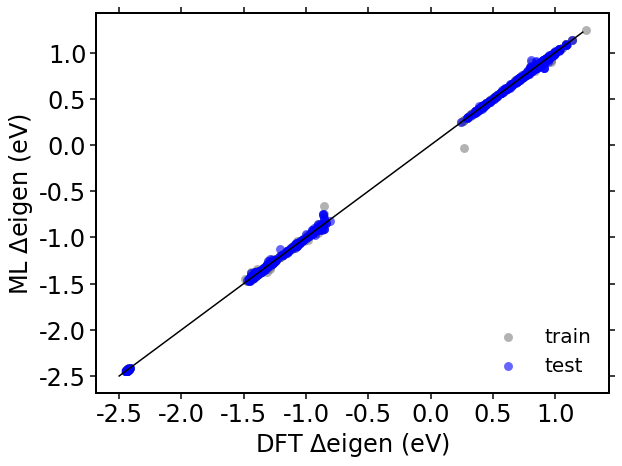

(4680, 16)
(4680,)
random seed 82
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(3744,) (936,)
0 RMSE 0.00442247767521993
0 MAE 0.00048188312930995544
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(3744,) (936,)
1 RMSE 0.003948310413048337
1 MAE 0.0002159008486070653
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.01}
(3744,) (936,)
2 RMSE 0.003997857762182857
2 MAE 0.0002658502238077154
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-05, 'gamma': 0.1}
(3744,) (936,)
3 RMSE 0.005477449940798752
3 MAE 0.0004218418573435109
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 1.0}
(3744,) (936,)
4 RMSE 0.01051133868970143
4 MAE 0.000633907871945438
best parameters gamma: 0.001 alpha: 1e-07
('MAE TRAIN ERROR', 3.837567251857814e-05)
('MAE TEST ERROR', 0.0002159008486070653)


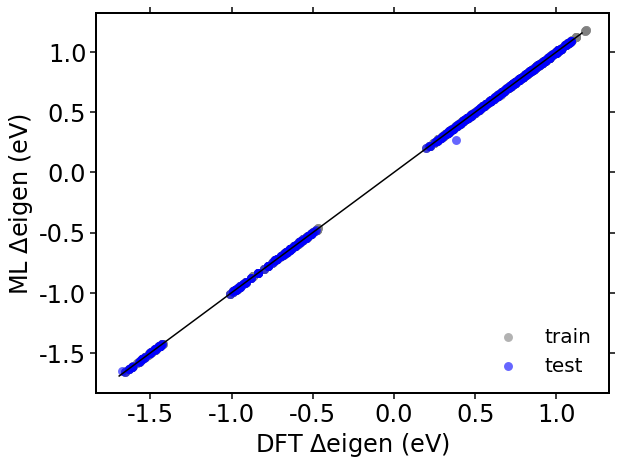

(4680, 16)
(4680,)
random seed 149
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(3744,) (936,)
0 RMSE 0.009890074692353364
0 MAE 0.0008717521741670629
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(3744,) (936,)
1 RMSE 0.010784892008416033
1 MAE 0.000712423669115696
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.01}
(3744,) (936,)
2 RMSE 0.009834514662106176
2 MAE 0.0005217486120955079
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.1}
(3744,) (936,)
3 RMSE 0.008195474794679006
3 MAE 0.0005389864469937936
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 1.0}
(3744,) (936,)
4 RMSE 0.011713892123229413
4 MAE 0.0010390613530167972
best parameters gamma: 0.01 alpha: 1e-07
('MAE TRAIN ERROR', 0.0001312045886474684)
('MAE TEST ERROR', 0.0005217486120955079)


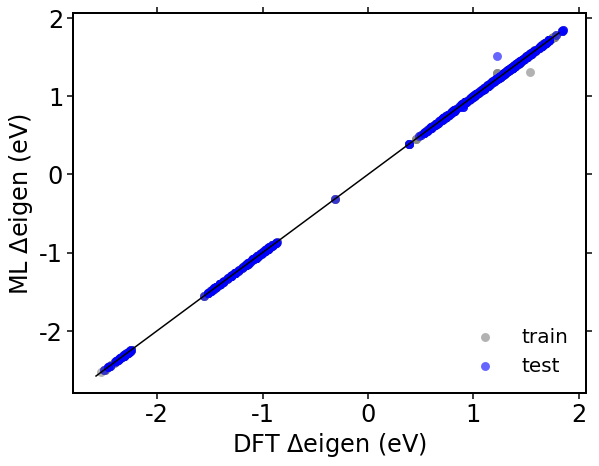

(4680, 16)
(4680,)
random seed 73
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(3744,) (936,)
0 RMSE 0.0005261501908918813
0 MAE 0.00018185032975078796
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(3744,) (936,)
1 RMSE 0.0003205812638249561
1 MAE 4.259427783970592e-05
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.01}
(3744,) (936,)
2 RMSE 0.0002515969416027793
2 MAE 2.582696724818852e-05
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.1}
(3744,) (936,)
3 RMSE 9.302780522886421e-05
3 MAE 8.753708676613707e-06
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 1.0}
(3744,) (936,)
4 RMSE 4.2742886990725496e-05
4 MAE 6.741363120647909e-06
best parameters gamma: 1.0 alpha: 1e-07
('MAE TRAIN ERROR', 1.956369307625197e-06)
('MAE TEST ERROR', 6.741363120647909e-06)


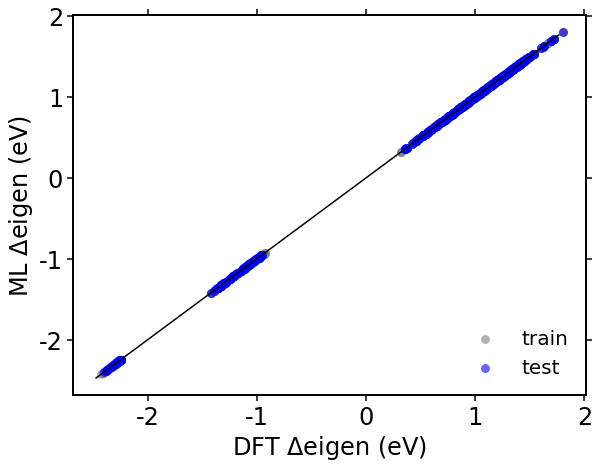

(3696, 16)
(3696,)
random seed 287
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(2956,) (740,)
0 RMSE 0.011183499560133672
0 MAE 0.004990592246937845
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(2956,) (740,)
1 RMSE 0.009337360025963975
1 MAE 0.0024850649675587366
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-05, 'gamma': 0.01}
(2956,) (740,)
2 RMSE 0.007495914228696261
2 MAE 0.0030797503914570855
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.0001, 'gamma': 0.1}
(2956,) (740,)
3 RMSE 0.006240554943400755
3 MAE 0.0023788586017484364
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.0001, 'gamma': 1.0}
(2956,) (740,)
4 RMSE 0.005999736838832715
4 MAE 0.0016978925164981462
best parameters gamma: 1.0 alpha: 0.0001
('MAE TRAIN ERROR', 4.205806445189248e-05)
('MAE TEST ERROR', 0.0016978925164981462)


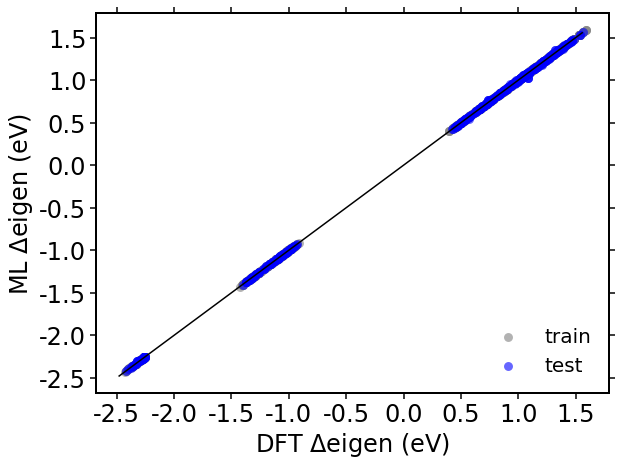

(4680, 16)
(4680,)
random seed 570
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(3744,) (936,)
0 RMSE 0.0016199332335658804
0 MAE 0.00041833326699792015
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(3744,) (936,)
1 RMSE 0.0009581784193707046
1 MAE 0.0001063271419845046
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.01}
(3744,) (936,)
2 RMSE 0.0007777735663788369
2 MAE 6.61500150510933e-05
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.1}
(3744,) (936,)
3 RMSE 0.0007884535857109099
3 MAE 5.6223027070792616e-05
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 1.0}
(3744,) (936,)
4 RMSE 0.0034559293140943173
4 MAE 0.00020000037884977803
best parameters gamma: 0.1 alpha: 1e-07
('MAE TRAIN ERROR', 8.040495337473942e-06)
('MAE TEST ERROR', 5.6223027070792616e-05)


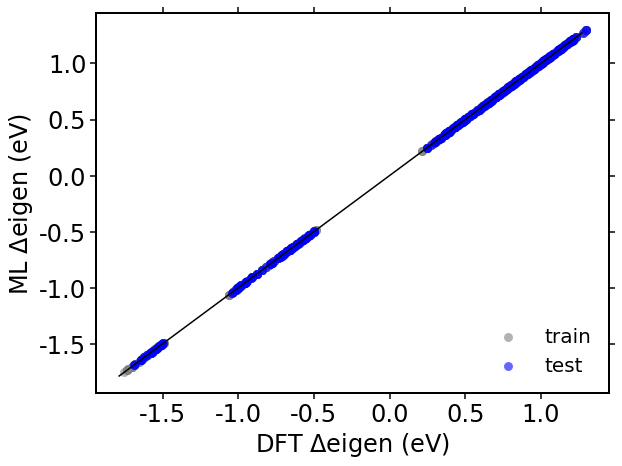

(6240, 16)
(6240,)
random seed 79
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(4992,) (1248,)
0 RMSE 0.005546067565913045
0 MAE 0.0009485089142949163
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.001}
(4992,) (1248,)
1 RMSE 0.005499547881843634
1 MAE 0.0009507547079910469
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-05, 'gamma': 0.01}
(4992,) (1248,)
2 RMSE 0.005428534972191769
2 MAE 0.0007957619144264902
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.0001, 'gamma': 0.1}
(4992,) (1248,)
3 RMSE 0.005803552013286659
3 MAE 0.0006875510923943103
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.001, 'gamma': 1.0}
(4992,) (1248,)
4 RMSE 0.007875405861392864
4 MAE 0.0006891940144980177
best parameters gamma: 0.1 alpha: 0.0001
('MAE TRAIN ERROR', 0.0002659102142931469)
('MAE TEST ERROR', 0.0006875510923943103)


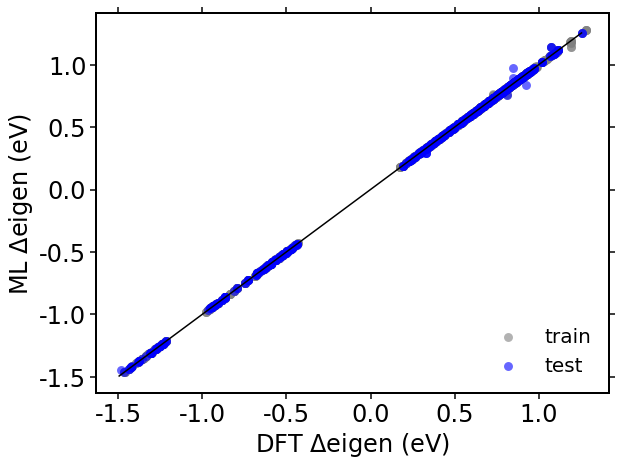

(4680, 16)
(4680,)
random seed 149
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(3744,) (936,)
0 RMSE 0.0011168089581509225
0 MAE 0.00017104886919487583
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(3744,) (936,)
1 RMSE 0.0009831160726612807
1 MAE 5.4193613575203565e-05
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.01}
(3744,) (936,)
2 RMSE 0.000782827784362223
2 MAE 3.616209467078589e-05
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.1}
(3744,) (936,)
3 RMSE 0.0007988172489292402
3 MAE 3.447785845071839e-05
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 1.0}
(3744,) (936,)
4 RMSE 0.008133410957796395
4 MAE 0.00027354295317270634
best parameters gamma: 0.1 alpha: 1e-07
('MAE TRAIN ERROR', 3.400330775156318e-07)
('MAE TEST ERROR', 3.447785845071839e-05)


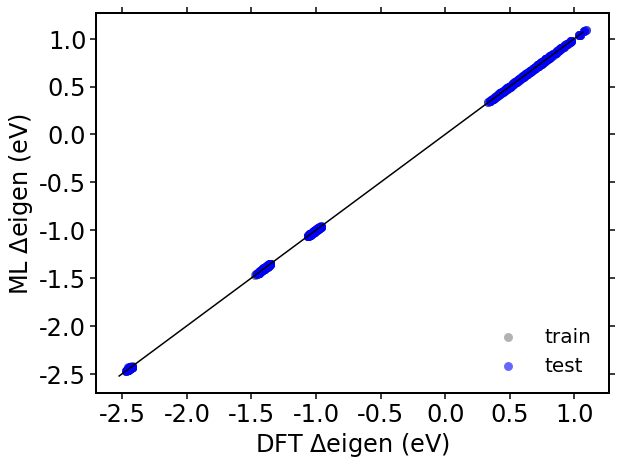

(4680, 16)
(4680,)
random seed 73
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(3744,) (936,)
0 RMSE 0.0023330874995362225
0 MAE 0.00030338863111719917
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(3744,) (936,)
1 RMSE 0.0021835894981966065
1 MAE 0.00011248802665028114
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.01}
(3744,) (936,)
2 RMSE 0.0020472464245462475
2 MAE 8.705944913010006e-05
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.1}
(3744,) (936,)
3 RMSE 0.0012460321398176364
3 MAE 5.5753631163577565e-05
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 1.0}
(3744,) (936,)
4 RMSE 0.0004247045029777475
4 MAE 2.6235532375111337e-05
best parameters gamma: 1.0 alpha: 1e-07
('MAE TRAIN ERROR', 1.0587004605008381e-05)
('MAE TEST ERROR', 2.6235532375111337e-05)


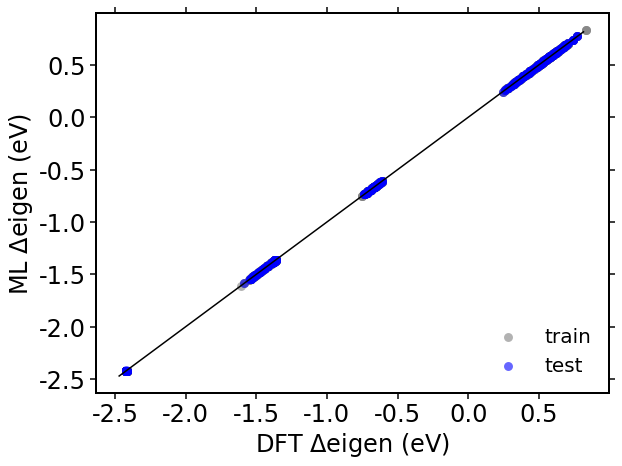

(3040, 16)
(3040,)
random seed 287
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.0001}
(2432,) (608,)
0 RMSE 0.028520342141327124
0 MAE 0.016395962100229658
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-05, 'gamma': 0.001}
(2432,) (608,)
1 RMSE 0.027567952289566416
1 MAE 0.015896816180249837
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-05, 'gamma': 0.01}
(2432,) (608,)
2 RMSE 0.023712822002032723
2 MAE 0.011782920383106368
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.0001, 'gamma': 0.1}
(2432,) (608,)
3 RMSE 0.022604661724713968
3 MAE 0.010793366973371977
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.001, 'gamma': 1.0}
(2432,) (608,)
4 RMSE 0.02256920403911478
4 MAE 0.010133818869123614
best parameters gamma: 1.0 alpha: 0.001
('MAE TRAIN ERROR', 0.0007639312444729605)
('MAE TEST ERROR', 0.010133818869123614)


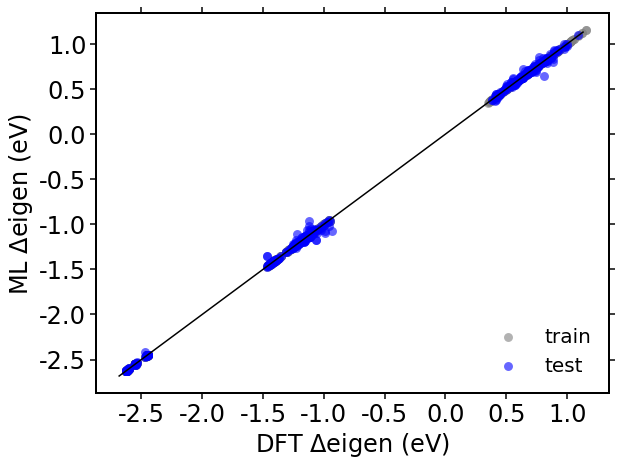

(4032, 16)
(4032,)
random seed 570
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(3225,) (807,)
0 RMSE 0.007358370064137184
0 MAE 0.002207608553086736
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(3225,) (807,)
1 RMSE 0.006574551099332338
1 MAE 0.0012622076151598668
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.01}
(3225,) (807,)
2 RMSE 0.005581898385496345
2 MAE 0.0009572144472729808
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.0001, 'gamma': 0.1}
(3225,) (807,)
3 RMSE 0.004879129410887937
3 MAE 0.0013123271589471958
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.001, 'gamma': 1.0}
(3225,) (807,)
4 RMSE 0.004716536404669098
4 MAE 0.0010276380567850747
best parameters gamma: 0.01 alpha: 1e-07
('MAE TRAIN ERROR', 4.2559854016267884e-05)
('MAE TEST ERROR', 0.0009572144472729808)


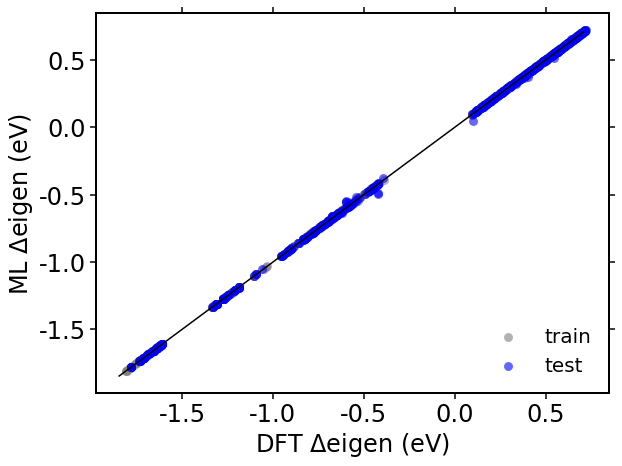

(3168, 16)
(3168,)
random seed 79
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(2534,) (634,)
0 RMSE 0.029247019038243022
0 MAE 0.007390121973944265
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(2534,) (634,)
1 RMSE 0.02831042402010562
1 MAE 0.00511134202253479
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.01}
(2534,) (634,)
2 RMSE 0.027645075075070667
2 MAE 0.004117829614504861
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.1}
(2534,) (634,)
3 RMSE 0.025715135284587062
3 MAE 0.003598339418246953
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 1.0}
(2534,) (634,)
4 RMSE 0.02408288645838768
4 MAE 0.0032066501421914857
best parameters gamma: 1.0 alpha: 1e-07
('MAE TRAIN ERROR', 1.2619644918680152e-06)
('MAE TEST ERROR', 0.0032066501421914857)


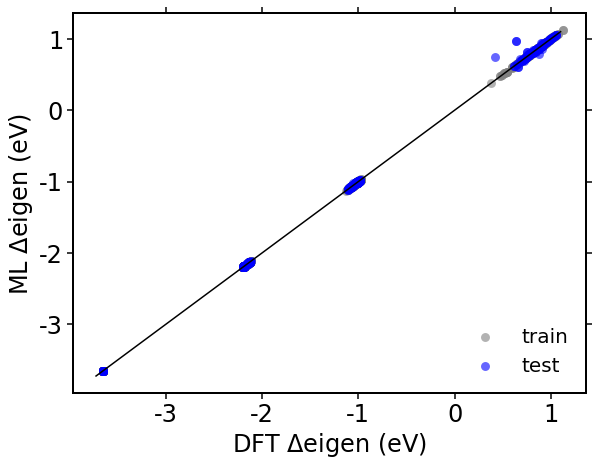

(5488, 16)
(5488,)
random seed 149
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(4390,) (1098,)
0 RMSE 0.016400359817893236
0 MAE 0.005121057916086662
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(4390,) (1098,)
1 RMSE 0.013525228236412827
1 MAE 0.0029459942491707374
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.01}
(4390,) (1098,)
2 RMSE 0.01269512266477279
2 MAE 0.002564495539402266
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-05, 'gamma': 0.1}
(4390,) (1098,)
3 RMSE 0.012143180059941416
3 MAE 0.002100006683572482
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.0001, 'gamma': 1.0}
(4390,) (1098,)
4 RMSE 0.013501050690219703
4 MAE 0.002316597125161004
best parameters gamma: 0.1 alpha: 1e-05
('MAE TRAIN ERROR', 0.00023613554934856797)
('MAE TEST ERROR', 0.002100006683572482)


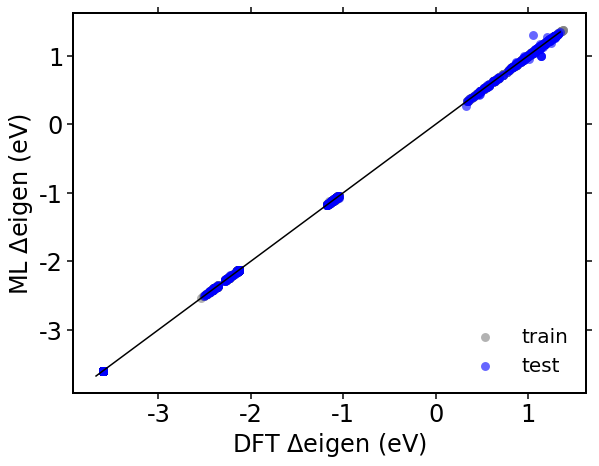

(3696, 16)
(3696,)
random seed 73
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(2956,) (740,)
0 RMSE 0.01685074577428823
0 MAE 0.006744110498337428
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.001}
(2956,) (740,)
1 RMSE 0.015608359225748753
1 MAE 0.006054684448382526
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.01}
(2956,) (740,)
2 RMSE 0.013986359141756848
2 MAE 0.0029371526475544417
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-05, 'gamma': 0.1}
(2956,) (740,)
3 RMSE 0.008827054897756252
3 MAE 0.0018867043014692063
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-05, 'gamma': 1.0}
(2956,) (740,)
4 RMSE 0.01660014462024842
4 MAE 0.001631031864387031
best parameters gamma: 1.0 alpha: 1e-05
('MAE TRAIN ERROR', 9.33975067846161e-06)
('MAE TEST ERROR', 0.001631031864387031)


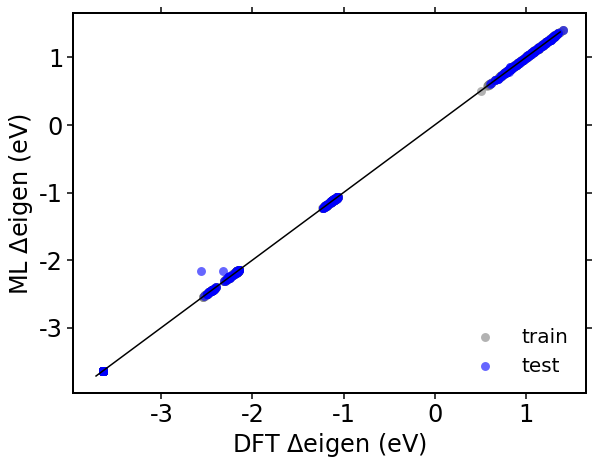

(4680, 16)
(4680,)
random seed 287
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(3744,) (936,)
0 RMSE 0.023519655652096346
0 MAE 0.0018963661925920393
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.001}
(3744,) (936,)
1 RMSE 0.023524035299258464
1 MAE 0.0018598887861852986
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-05, 'gamma': 0.01}
(3744,) (936,)
2 RMSE 0.023554252545912414
2 MAE 0.0017755494640285586
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.0001, 'gamma': 0.1}
(3744,) (936,)
3 RMSE 0.023658092651466
3 MAE 0.0016671603484866469
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.001, 'gamma': 1.0}
(3744,) (936,)
4 RMSE 0.023903167045026256
4 MAE 0.0016799395719897265
best parameters gamma: 0.1 alpha: 0.0001
('MAE TRAIN ERROR', 0.0006448512632671447)
('MAE TEST ERROR', 0.0016671603484866469)


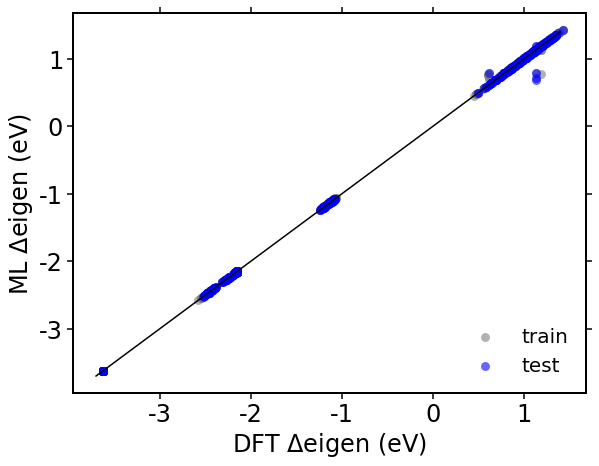

(4680, 16)
(4680,)
random seed 570
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(3744,) (936,)
0 RMSE 0.02576123458692814
0 MAE 0.0019521925232971714
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.001}
(3744,) (936,)
1 RMSE 0.025435825304801762
1 MAE 0.0019373872194256403
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.01}
(3744,) (936,)
2 RMSE 0.024615339674393534
2 MAE 0.001455209147443983
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.1}
(3744,) (936,)
3 RMSE 0.01859980010005426
3 MAE 0.0011400449706903141
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.0001, 'gamma': 1.0}
(3744,) (936,)
4 RMSE 0.01355812944393674
4 MAE 0.0009005716663960433
best parameters gamma: 1.0 alpha: 0.0001
('MAE TRAIN ERROR', 0.00016664066289803425)
('MAE TEST ERROR', 0.0009005716663960433)


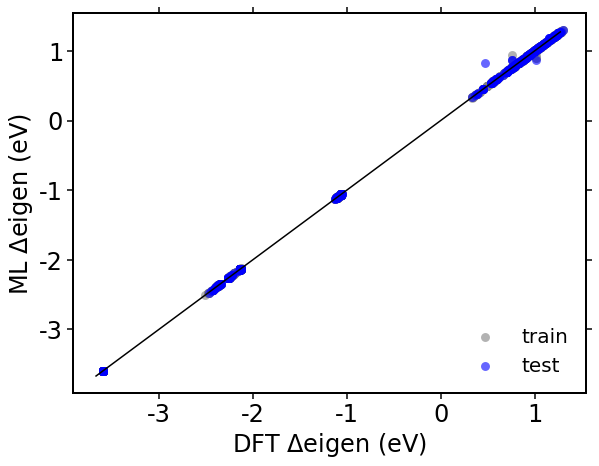

(5488, 16)
(5488,)
random seed 79
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(4390,) (1098,)
0 RMSE 0.02598108126347946
0 MAE 0.007394754944019955
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(4390,) (1098,)
1 RMSE 0.025837605360697912
1 MAE 0.0043884827807364165
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.01}
(4390,) (1098,)
2 RMSE 0.02661250907639386
2 MAE 0.004154506729783025
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.1}
(4390,) (1098,)
3 RMSE 0.02357471674398898
3 MAE 0.002959308022956597
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-05, 'gamma': 1.0}
(4390,) (1098,)
4 RMSE 0.017512412383113997
4 MAE 0.0025292226334182122
best parameters gamma: 1.0 alpha: 1e-05
('MAE TRAIN ERROR', 0.00010425780292562169)
('MAE TEST ERROR', 0.0025292226334182122)


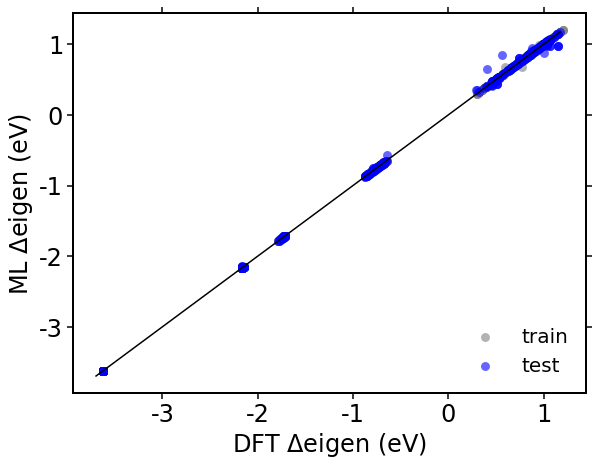

(3696, 16)
(3696,)
random seed 149
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(2956,) (740,)
0 RMSE 0.01035413968951599
0 MAE 0.004945701132769498
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(2956,) (740,)
1 RMSE 0.006930033568624491
1 MAE 0.0023943527308416352
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.01}
(2956,) (740,)
2 RMSE 0.0048916557496826866
2 MAE 0.0016192204797995206
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.1}
(2956,) (740,)
3 RMSE 0.003819724796340692
3 MAE 0.0010873829563227842
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.0001, 'gamma': 1.0}
(2956,) (740,)
4 RMSE 0.007122120761638389
4 MAE 0.0012884237121989538
best parameters gamma: 0.1 alpha: 1e-06
('MAE TRAIN ERROR', 0.00014119753017868809)
('MAE TEST ERROR', 0.0010873829563227842)


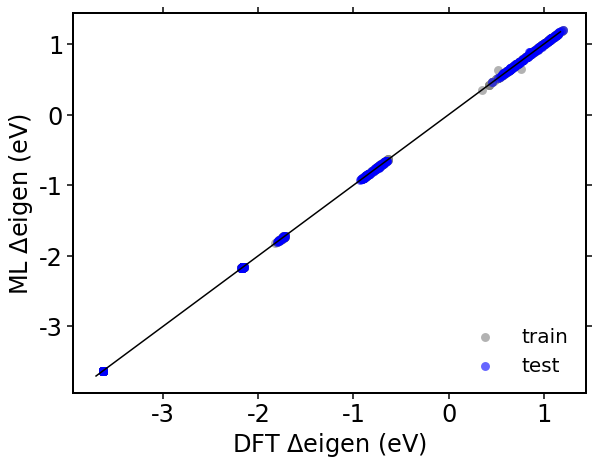

(4680, 16)
(4680,)
random seed 73
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(3744,) (936,)
0 RMSE 0.007996019661477347
0 MAE 0.0010819148807530796
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.001}
(3744,) (936,)
1 RMSE 0.007991441746059307
1 MAE 0.0010682691706140526
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-05, 'gamma': 0.01}
(3744,) (936,)
2 RMSE 0.007954313556650544
2 MAE 0.0009945757759427252
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.0001, 'gamma': 0.1}
(3744,) (936,)
3 RMSE 0.007882345370609518
3 MAE 0.0008484811482722223
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 1.0}
(3744,) (936,)
4 RMSE 0.003974946807868732
4 MAE 0.0003156565654175518
best parameters gamma: 1.0 alpha: 1e-07
('MAE TRAIN ERROR', 9.301231653011898e-05)
('MAE TEST ERROR', 0.0003156565654175518)


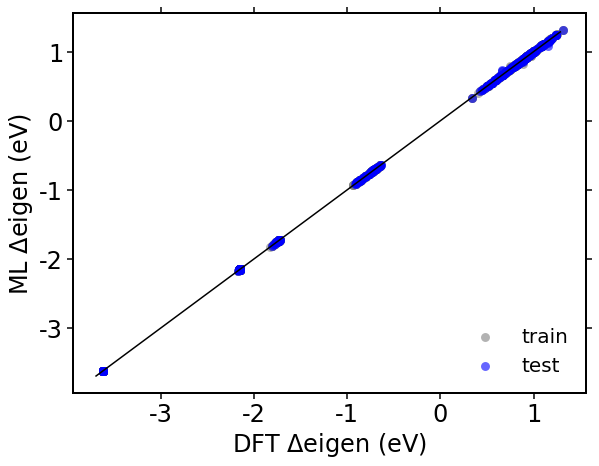

(4680, 16)
(4680,)
random seed 287
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(3744,) (936,)
0 RMSE 0.003469174767539282
0 MAE 0.0005302620140630715
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(3744,) (936,)
1 RMSE 0.0032453264447187997
1 MAE 0.00023220220070009078
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.01}
(3744,) (936,)
2 RMSE 0.0026270444149821895
2 MAE 0.0001401748343013894
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.1}
(3744,) (936,)
3 RMSE 0.0015767729007400328
3 MAE 0.00010082951513246498
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.0001, 'gamma': 1.0}
(3744,) (936,)
4 RMSE 0.004888301631881372
4 MAE 0.00036963572353883713
best parameters gamma: 0.1 alpha: 1e-07
('MAE TRAIN ERROR', 3.2500237814443204e-06)
('MAE TEST ERROR', 0.00010082951513246498)


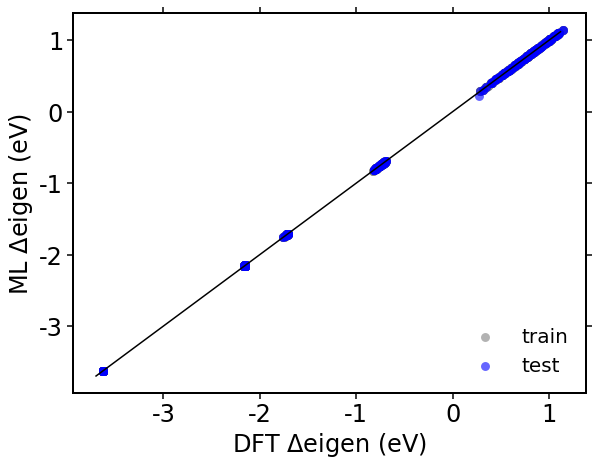

(5488, 16)
(5488,)
random seed 570
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(4390,) (1098,)
0 RMSE 0.012969602291973411
0 MAE 0.00514878562176662
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(4390,) (1098,)
1 RMSE 0.010404547901327353
1 MAE 0.002427315488854574
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.01}
(4390,) (1098,)
2 RMSE 0.010963530171586201
2 MAE 0.0023081194952609832
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-05, 'gamma': 0.1}
(4390,) (1098,)
3 RMSE 0.011023758808756418
3 MAE 0.0021119361816264383
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.001, 'gamma': 1.0}
(4390,) (1098,)
4 RMSE 0.009163102895594546
4 MAE 0.0025368450581443676
best parameters gamma: 0.1 alpha: 1e-05
('MAE TRAIN ERROR', 0.0005797520486934388)
('MAE TEST ERROR', 0.0021119361816264383)


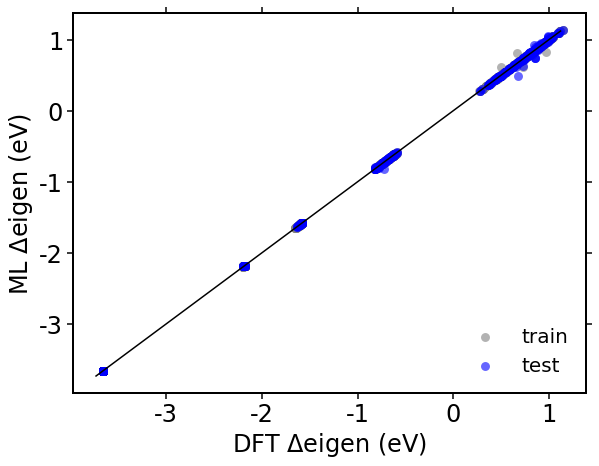

(3696, 16)
(3696,)
random seed 79
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(2956,) (740,)
0 RMSE 0.012105599407958901
0 MAE 0.005759359861923925
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(2956,) (740,)
1 RMSE 0.0069700130005277555
1 MAE 0.0023423825769318908
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.01}
(2956,) (740,)
2 RMSE 0.005964463416205728
2 MAE 0.0014481187519915768
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.1}
(2956,) (740,)
3 RMSE 0.007632709058288404
3 MAE 0.001891809177400015
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 1.0}
(2956,) (740,)
4 RMSE 0.009457668878840163
4 MAE 0.0020878568997581724
best parameters gamma: 0.01 alpha: 1e-07
('MAE TRAIN ERROR', 0.00022154078289435364)
('MAE TEST ERROR', 0.0014481187519915768)


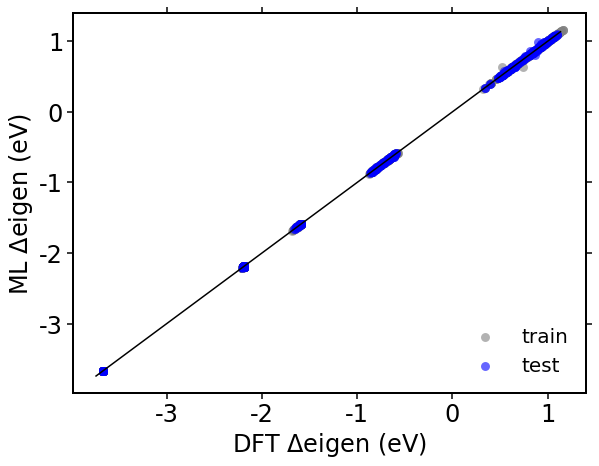

(4680, 16)
(4680,)
random seed 149
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(3744,) (936,)
0 RMSE 0.0009592750324622864
0 MAE 0.0003791789881563278
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(3744,) (936,)
1 RMSE 0.0003469922239649401
1 MAE 7.051986104914777e-05
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.01}
(3744,) (936,)
2 RMSE 0.00038467366548540293
2 MAE 6.742126781583174e-05
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.0001, 'gamma': 0.1}
(3744,) (936,)
3 RMSE 0.0006773899505054823
3 MAE 0.0002468299926971079
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.001, 'gamma': 1.0}
(3744,) (936,)
4 RMSE 0.0005436732715140895
4 MAE 0.0001819481695489099
best parameters gamma: 0.01 alpha: 1e-06
('MAE TRAIN ERROR', 2.846959843742448e-05)
('MAE TEST ERROR', 6.742126781583174e-05)


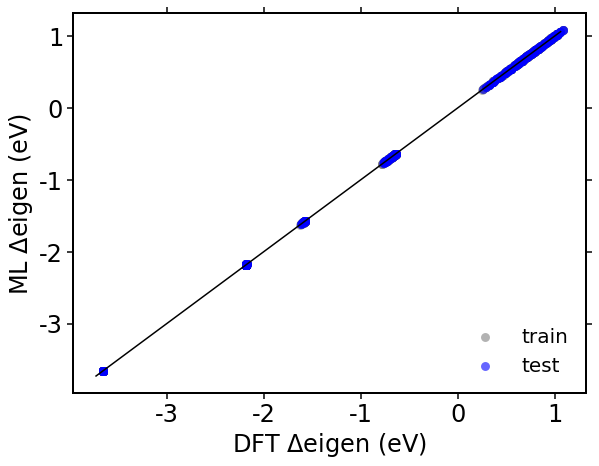

(4680, 16)
(4680,)
random seed 73
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(3744,) (936,)
0 RMSE 0.022234034857726365
0 MAE 0.0018975911962193486
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.001}
(3744,) (936,)
1 RMSE 0.021476702641442042
1 MAE 0.0018495435175988361
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-05, 'gamma': 0.01}
(3744,) (936,)
2 RMSE 0.019740222057964357
2 MAE 0.0017005903538952613
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.0001, 'gamma': 0.1}
(3744,) (936,)
3 RMSE 0.015990235683306188
3 MAE 0.0013385786087059025
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 1.0}
(3744,) (936,)
4 RMSE 0.009918168058035687
4 MAE 0.000528623619143854
best parameters gamma: 1.0 alpha: 1e-07
('MAE TRAIN ERROR', 6.511265206120626e-06)
('MAE TEST ERROR', 0.000528623619143854)


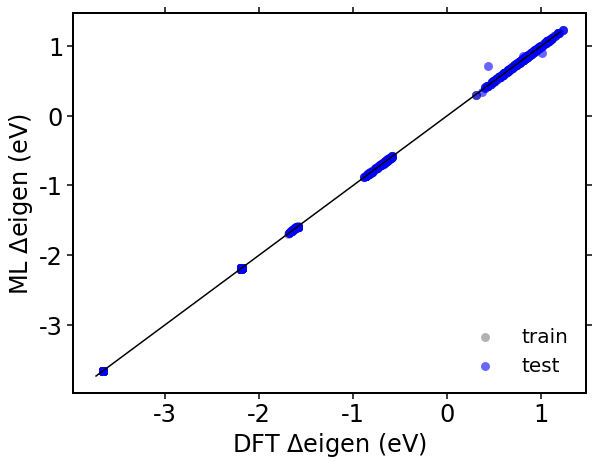

(6840, 16)
(6840,)
random seed 287
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(5472,) (1368,)
0 RMSE 0.013910268316202425
0 MAE 0.004566751322996688
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(5472,) (1368,)
1 RMSE 0.01196547173421491
1 MAE 0.002349016348141362
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.01}
(5472,) (1368,)
2 RMSE 0.011333736567730611
2 MAE 0.0023084726801024086
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.1}
(5472,) (1368,)
3 RMSE 0.010328653798525907
3 MAE 0.001561611819023969
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 1.0}
(5472,) (1368,)
4 RMSE 0.008242127440512477
4 MAE 0.0016616404868832443
best parameters gamma: 0.1 alpha: 1e-07
('MAE TRAIN ERROR', 9.507951981306391e-06)
('MAE TEST ERROR', 0.001561611819023969)


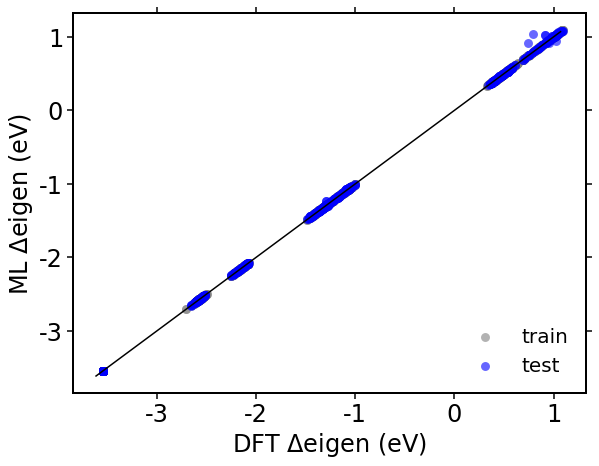

(4816, 16)
(4816,)
random seed 570
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(3852,) (964,)
0 RMSE 0.007147789060537936
0 MAE 0.0004946525379518355
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.001}
(3852,) (964,)
1 RMSE 0.006393233015470012
1 MAE 0.0004440216604193094
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-05, 'gamma': 0.01}
(3852,) (964,)
2 RMSE 0.004715181466264125
2 MAE 0.0003274072203697694
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.0001, 'gamma': 0.1}
(3852,) (964,)
3 RMSE 0.0025806527448283844
3 MAE 0.00020274671146330202
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-05, 'gamma': 1.0}
(3852,) (964,)
4 RMSE 0.0050715884152394254
4 MAE 0.00021383454953535796
best parameters gamma: 0.1 alpha: 0.0001
('MAE TRAIN ERROR', 7.338800626809978e-05)
('MAE TEST ERROR', 0.00020274671146330202)


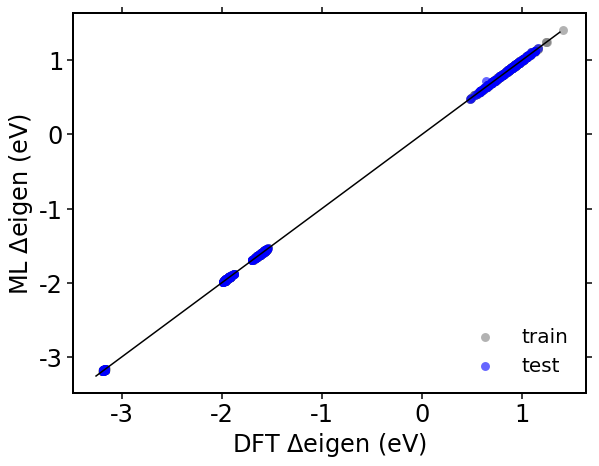

(5832, 16)
(5832,)
random seed 79
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(4665,) (1167,)
0 RMSE 0.036986300752728254
0 MAE 0.0035028928333502387
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.001}
(4665,) (1167,)
1 RMSE 0.03229831956633022
1 MAE 0.0030298159015795943
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-05, 'gamma': 0.01}
(4665,) (1167,)
2 RMSE 0.02779643070710767
2 MAE 0.0027390701064872805
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-05, 'gamma': 0.1}
(4665,) (1167,)
3 RMSE 0.027713810089434538
3 MAE 0.002155189240189397
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.001, 'gamma': 1.0}
(4665,) (1167,)
4 RMSE 0.02885464470958189
4 MAE 0.0025039967119032933
best parameters gamma: 0.1 alpha: 1e-05
('MAE TRAIN ERROR', 7.367845231367673e-05)
('MAE TEST ERROR', 0.002155189240189397)


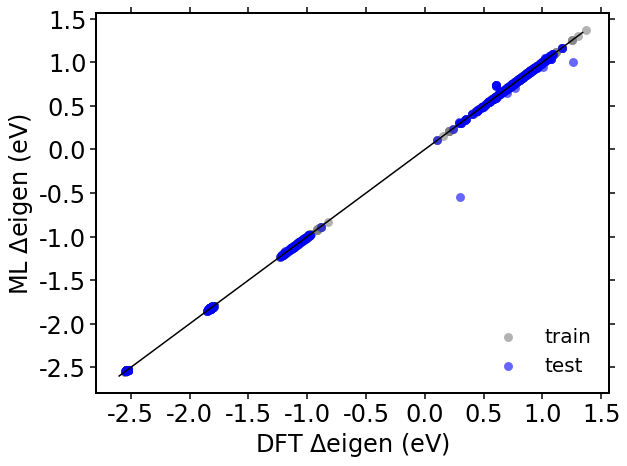

(4752, 16)
(4752,)
random seed 149
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(3801,) (951,)
0 RMSE 0.01704068048367231
0 MAE 0.005119632787790022
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.001}
(3801,) (951,)
1 RMSE 0.015574176340472016
1 MAE 0.00466040410923551
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.01}
(3801,) (951,)
2 RMSE 0.012983458955777894
2 MAE 0.0027743088450866184
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.1}
(3801,) (951,)
3 RMSE 0.011049139357159801
3 MAE 0.0023290770040749025
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 1.0}
(3801,) (951,)
4 RMSE 0.014746658777055803
4 MAE 0.002380288115884334
best parameters gamma: 0.1 alpha: 1e-07
('MAE TRAIN ERROR', 0.00010429104396086377)
('MAE TEST ERROR', 0.0023290770040749025)


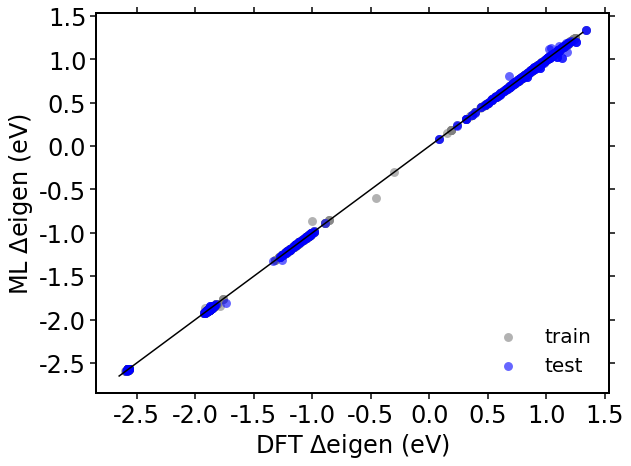

(6240, 16)
(6240,)
random seed 73
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(4992,) (1248,)
0 RMSE 0.03474764093608111
0 MAE 0.0012701711867082843
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(4992,) (1248,)
1 RMSE 0.030650305606412968
1 MAE 0.0009718618468859774
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.01}
(4992,) (1248,)
2 RMSE 0.023984577893911722
2 MAE 0.000766621210910659
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.0001, 'gamma': 0.1}
(4992,) (1248,)
3 RMSE 0.02066900615962205
3 MAE 0.0007733169066336096
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 1.0}
(4992,) (1248,)
4 RMSE 0.016758916234070782
4 MAE 0.0006293956695505662
best parameters gamma: 1.0 alpha: 1e-07
('MAE TRAIN ERROR', 4.87787027109547e-07)
('MAE TEST ERROR', 0.0006293956695505662)


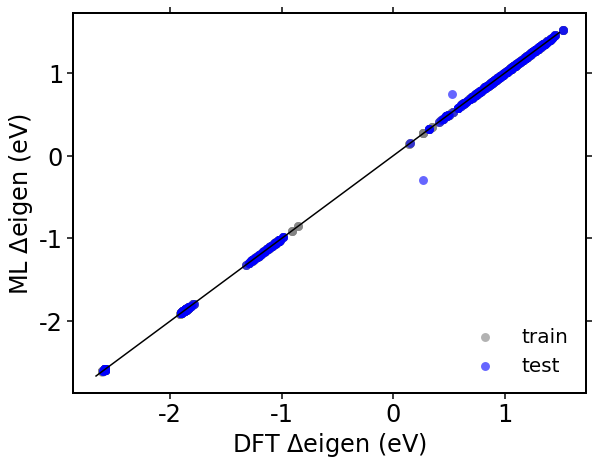

(4752, 16)
(4752,)
random seed 287
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(3801,) (951,)
0 RMSE 0.035730273284925826
0 MAE 0.004565685671592935
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.001}
(3801,) (951,)
1 RMSE 0.03562117419084592
1 MAE 0.00418882478817712
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-05, 'gamma': 0.01}
(3801,) (951,)
2 RMSE 0.035477526242681724
2 MAE 0.0033765336196649298
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.0001, 'gamma': 0.1}
(3801,) (951,)
3 RMSE 0.0353812159642751
3 MAE 0.0026762207854176454
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 1.0}
(3801,) (951,)
4 RMSE 0.035538946044955486
4 MAE 0.0020181082780458466
best parameters gamma: 1.0 alpha: 1e-07
('MAE TRAIN ERROR', 4.579801830191762e-08)
('MAE TEST ERROR', 0.0020181082780458466)


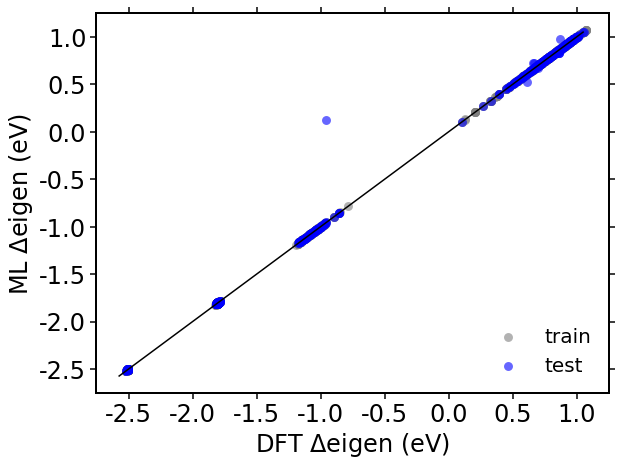

(6240, 16)
(6240,)
random seed 570
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(4992,) (1248,)
0 RMSE 0.013776451092127846
0 MAE 0.0007517140686141269
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(4992,) (1248,)
1 RMSE 0.013929980371942532
1 MAE 0.0005760611253308038
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-05, 'gamma': 0.01}
(4992,) (1248,)
2 RMSE 0.01417971026628077
2 MAE 0.0006848159558030495
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.001, 'gamma': 0.1}
(4992,) (1248,)
3 RMSE 0.01624376292687355
3 MAE 0.0010814219161908365
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.1, 'gamma': 1.0}
(4992,) (1248,)
4 RMSE 0.033903382584059685
4 MAE 0.0038665635310528887
best parameters gamma: 0.001 alpha: 1e-07
('MAE TRAIN ERROR', 0.0002539442294881388)
('MAE TEST ERROR', 0.0005760611253308038)


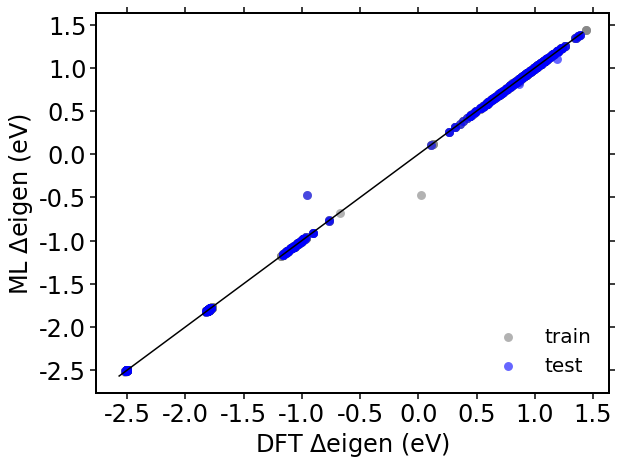

(4752, 16)
(4752,)
random seed 79
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(3801,) (951,)
0 RMSE 0.025522688324638627
0 MAE 0.0075382187191626975
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(3801,) (951,)
1 RMSE 0.024444364927444593
1 MAE 0.005037916360864648
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.01}
(3801,) (951,)
2 RMSE 0.02356453531748091
2 MAE 0.004228859141542824
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.1}
(3801,) (951,)
3 RMSE 0.022754834084313252
3 MAE 0.00424020759511586
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-05, 'gamma': 1.0}
(3801,) (951,)
4 RMSE 0.019672267908775895
4 MAE 0.003997592380252325
best parameters gamma: 1.0 alpha: 1e-05
('MAE TRAIN ERROR', 5.241664038786615e-05)
('MAE TEST ERROR', 0.003997592380252325)


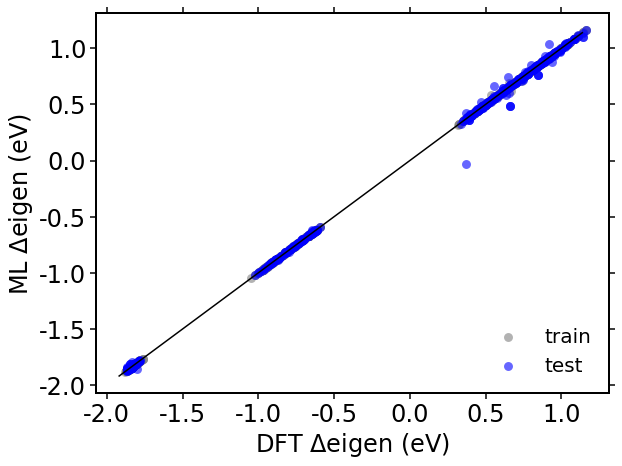

(6240, 16)
(6240,)
random seed 149
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(4992,) (1248,)
0 RMSE 0.008870282498281982
0 MAE 0.0009320277819108636
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(4992,) (1248,)
1 RMSE 0.008766797271528699
1 MAE 0.0005150018324777672
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.01}
(4992,) (1248,)
2 RMSE 0.007850751758092972
2 MAE 0.00040820615393889135
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.1}
(4992,) (1248,)
3 RMSE 0.006807765757894262
3 MAE 0.00029184871337880274
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 1.0}
(4992,) (1248,)
4 RMSE 0.008331527123748529
4 MAE 0.00034728116054009084
best parameters gamma: 0.1 alpha: 1e-07
('MAE TRAIN ERROR', 4.8438729637031405e-06)
('MAE TEST ERROR', 0.00029184871337880274)


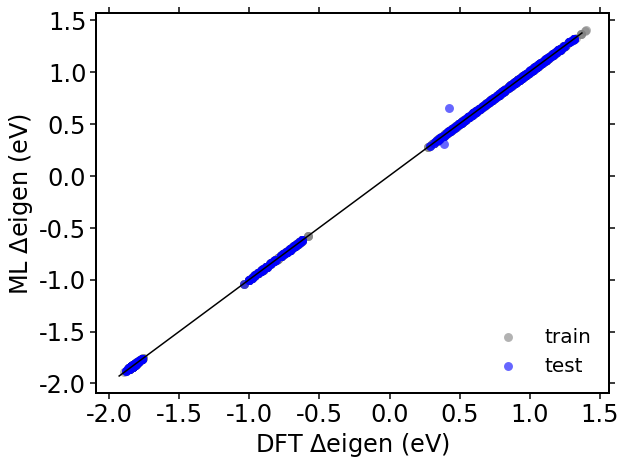

(4752, 16)
(4752,)
random seed 73
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(3801,) (951,)
0 RMSE 0.012713105589292806
0 MAE 0.003927395428305299
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(3801,) (951,)
1 RMSE 0.012314373216314461
1 MAE 0.002240780494988785
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.01}
(3801,) (951,)
2 RMSE 0.011899144743030918
2 MAE 0.00215332489361282
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.1}
(3801,) (951,)
3 RMSE 0.010733321918616243
3 MAE 0.0018560435577502454
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 1.0}
(3801,) (951,)
4 RMSE 0.010092796068132036
4 MAE 0.0015085370461672438
best parameters gamma: 1.0 alpha: 1e-06
('MAE TRAIN ERROR', 7.821956347898279e-07)
('MAE TEST ERROR', 0.0015085370461672438)


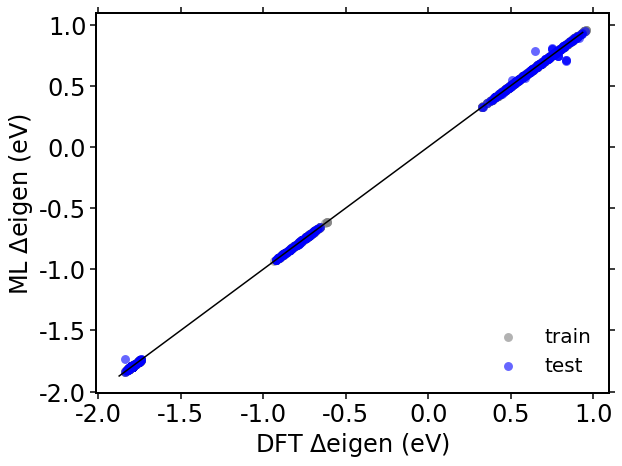

(6240, 16)
(6240,)
random seed 287
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(4992,) (1248,)
0 RMSE 0.0062547060837627065
0 MAE 0.0009628163716879346
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(4992,) (1248,)
1 RMSE 0.006260833125516825
1 MAE 0.0006615239409213113
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-05, 'gamma': 0.01}
(4992,) (1248,)
2 RMSE 0.00639168381520512
2 MAE 0.0008866191399280515
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.0001, 'gamma': 0.1}
(4992,) (1248,)
3 RMSE 0.00700510930181556
3 MAE 0.0007936560383795554
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 1.0}
(4992,) (1248,)
4 RMSE 0.008549224158977712
4 MAE 0.0007167549338701843
best parameters gamma: 0.001 alpha: 1e-07
('MAE TRAIN ERROR', 5.723090654967034e-05)
('MAE TEST ERROR', 0.0006615239409213113)


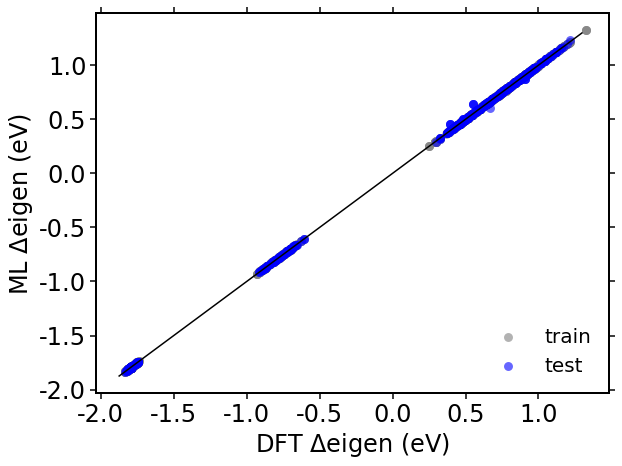

(4752, 16)
(4752,)
random seed 570
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(3801,) (951,)
0 RMSE 0.014215676861668055
0 MAE 0.004775774588119428
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.001}
(3801,) (951,)
1 RMSE 0.012659550287645543
1 MAE 0.004465902480236049
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-05, 'gamma': 0.01}
(3801,) (951,)
2 RMSE 0.010134050150063367
2 MAE 0.0038974614257435234
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.001, 'gamma': 0.1}
(3801,) (951,)
3 RMSE 0.009109092497122814
3 MAE 0.004668629052577124
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.01, 'gamma': 1.0}
(3801,) (951,)
4 RMSE 0.010937812134976218
4 MAE 0.003948337561737751
best parameters gamma: 0.01 alpha: 1e-05
('MAE TRAIN ERROR', 0.0014445477130042965)
('MAE TEST ERROR', 0.0038974614257435234)


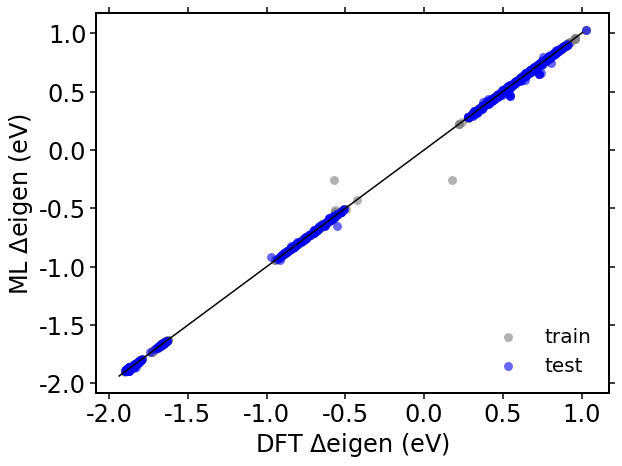

(4752, 16)
(4752,)
random seed 79
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(3801,) (951,)
0 RMSE 0.006090024681177639
0 MAE 0.0027892902458101668
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(3801,) (951,)
1 RMSE 0.004832190848099123
1 MAE 0.0010967903094054922
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.01}
(3801,) (951,)
2 RMSE 0.005496675200675998
2 MAE 0.0011677230050312595
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.0001, 'gamma': 0.1}
(3801,) (951,)
3 RMSE 0.0059876807771282094
3 MAE 0.0016342151648958453
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.001, 'gamma': 1.0}
(3801,) (951,)
4 RMSE 0.005918345706685674
4 MAE 0.0011833305681261978
best parameters gamma: 0.001 alpha: 1e-07
('MAE TRAIN ERROR', 0.00030163636731582173)
('MAE TEST ERROR', 0.0010967903094054922)


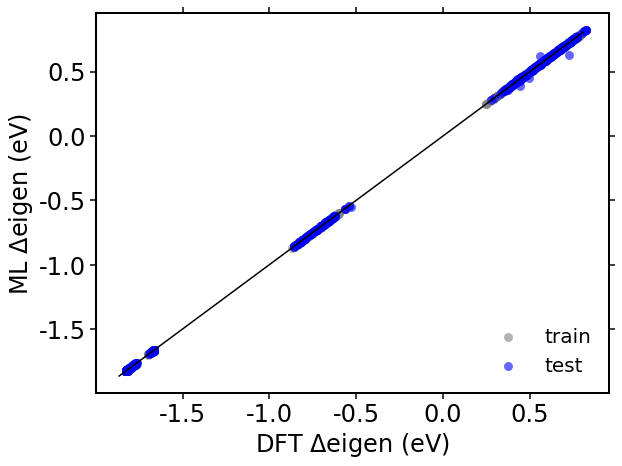

(6240, 16)
(6240,)
random seed 149
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(4992,) (1248,)
0 RMSE 0.007064740213293853
0 MAE 0.0007329581970418938
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.001}
(4992,) (1248,)
1 RMSE 0.00709079048393406
1 MAE 0.0007007443616442274
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-05, 'gamma': 0.01}
(4992,) (1248,)
2 RMSE 0.0070952770251618055
2 MAE 0.0006081151958636716
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.0001, 'gamma': 0.1}
(4992,) (1248,)
3 RMSE 0.00679931121007439
3 MAE 0.0004748893484343598
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-05, 'gamma': 1.0}
(4992,) (1248,)
4 RMSE 0.005637795982663194
4 MAE 0.00034856952530521124
best parameters gamma: 1.0 alpha: 1e-05
('MAE TRAIN ERROR', 2.493101554739727e-05)
('MAE TEST ERROR', 0.00034856952530521124)


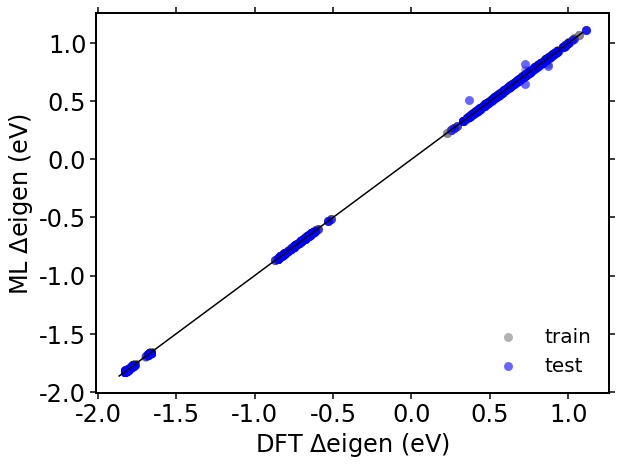

(7280, 16)
(7280,)
random seed 73
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(5824,) (1456,)
0 RMSE 0.0035621003461818045
0 MAE 0.0008558011785373409
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.001}
(5824,) (1456,)
1 RMSE 0.0035080931552026835
1 MAE 0.0007852549274755947
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-05, 'gamma': 0.01}
(5824,) (1456,)
2 RMSE 0.0033164571950688023
2 MAE 0.0005789474044063732
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.0001, 'gamma': 0.1}
(5824,) (1456,)
3 RMSE 0.00318934073996127
3 MAE 0.000356705918542204
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.001, 'gamma': 1.0}
(5824,) (1456,)
4 RMSE 0.003037190976918354
4 MAE 0.00022390558181500678
best parameters gamma: 1.0 alpha: 0.001
('MAE TRAIN ERROR', 0.00017408605901678994)
('MAE TEST ERROR', 0.00022390558181500678)


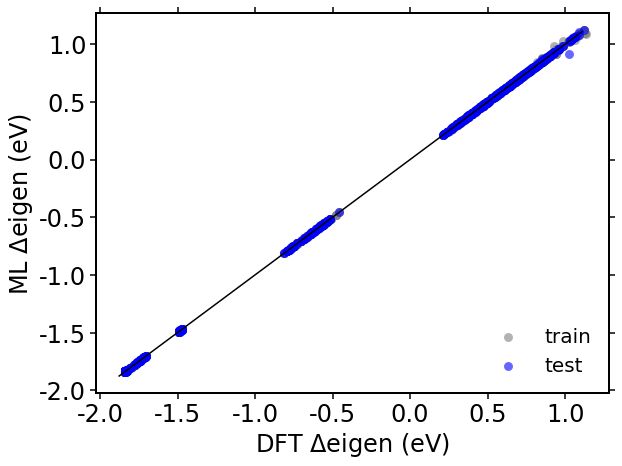

(7952, 16)
(7952,)
random seed 287
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(6361,) (1591,)
0 RMSE 0.048502104217858596
0 MAE 0.028339031432683303
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(6361,) (1591,)
1 RMSE 0.03757390214075143
1 MAE 0.01680904395601493
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.01}
(6361,) (1591,)
2 RMSE 0.04221139011715805
2 MAE 0.019066398994464127
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.0001, 'gamma': 0.1}
(6361,) (1591,)
3 RMSE 0.05512822478165706
3 MAE 0.028147260433779266
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.001, 'gamma': 1.0}
(6361,) (1591,)
4 RMSE 0.06275608810649476
4 MAE 0.02797834628415092
best parameters gamma: 0.001 alpha: 1e-07
('MAE TRAIN ERROR', 0.0037188911567901987)
('MAE TEST ERROR', 0.01680904395601493)


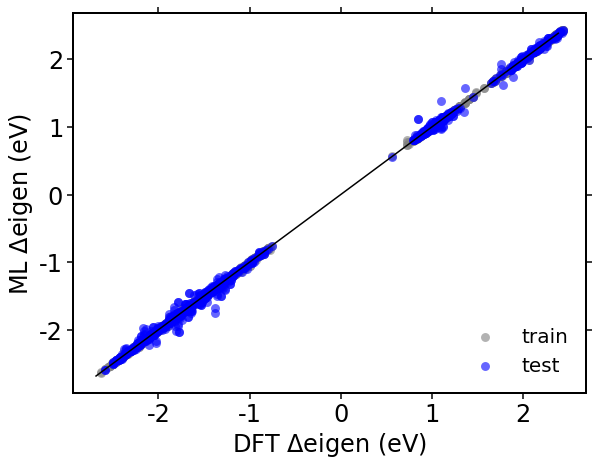

(7056, 16)
(7056,)
random seed 570
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(5644,) (1412,)
0 RMSE 0.03664791312083579
0 MAE 0.015147622844188921
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(5644,) (1412,)
1 RMSE 0.032423518543334945
1 MAE 0.009486894398113118
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.01}
(5644,) (1412,)
2 RMSE 0.027835219588676127
2 MAE 0.0070407712811951725
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.1}
(5644,) (1412,)
3 RMSE 0.0261885816227914
3 MAE 0.007076046790892423
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 1.0}
(5644,) (1412,)
4 RMSE 0.03121091866189982
4 MAE 0.009192552964980366
best parameters gamma: 0.01 alpha: 1e-07
('MAE TRAIN ERROR', 0.0004946946784794919)
('MAE TEST ERROR', 0.0070407712811951725)


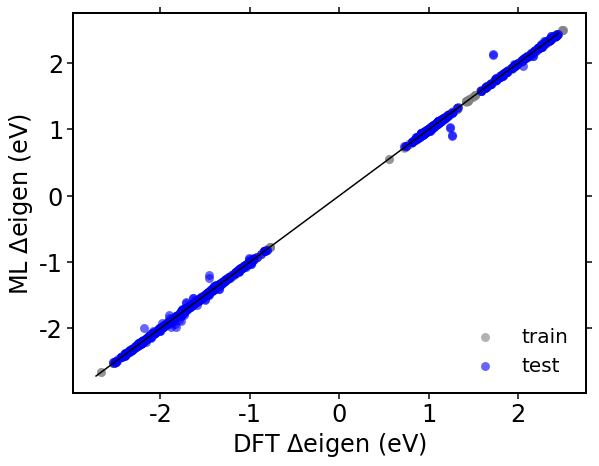

(7560, 16)
(7560,)
random seed 79
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(6048,) (1512,)
0 RMSE 0.01274188629417173
0 MAE 0.002738226797073674
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(6048,) (1512,)
1 RMSE 0.012816998251525897
1 MAE 0.0022644171358840275
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.01}
(6048,) (1512,)
2 RMSE 0.013578229534848267
2 MAE 0.0019269523962539771
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.0001, 'gamma': 0.1}
(6048,) (1512,)
3 RMSE 0.012573164638040337
3 MAE 0.0022388660797236933
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.001, 'gamma': 1.0}
(6048,) (1512,)
4 RMSE 0.011582379492756298
4 MAE 0.0016936099315354581
best parameters gamma: 1.0 alpha: 0.001
('MAE TRAIN ERROR', 0.0007063740271438326)
('MAE TEST ERROR', 0.0016936099315354581)


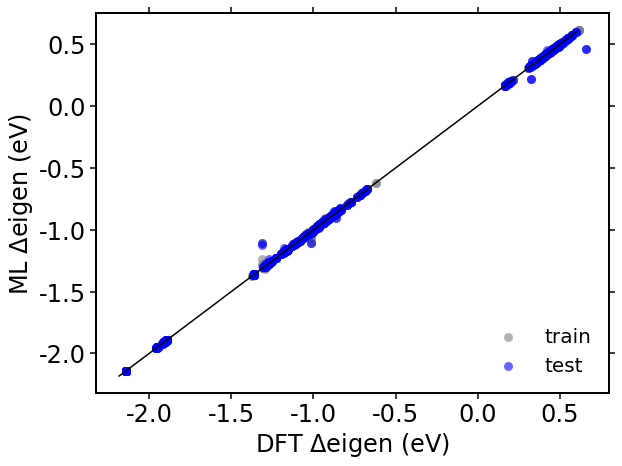

(9504, 16)
(9504,)
random seed 149
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(7603,) (1901,)
0 RMSE 0.0033090331824942127
0 MAE 0.002084371434054325
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(7603,) (1901,)
1 RMSE 0.0013499907898691457
1 MAE 0.0006069724504820115
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.01}
(7603,) (1901,)
2 RMSE 0.0011707387214552583
2 MAE 0.0003088162564966159
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-05, 'gamma': 0.1}
(7603,) (1901,)
3 RMSE 0.001314906288943499
3 MAE 0.0004409777094287847
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 1.0}
(7603,) (1901,)
4 RMSE 0.0010603568347802245
4 MAE 0.00025768297771736813
best parameters gamma: 1.0 alpha: 1e-06
('MAE TRAIN ERROR', 2.4306437637841777e-06)
('MAE TEST ERROR', 0.00025768297771736813)


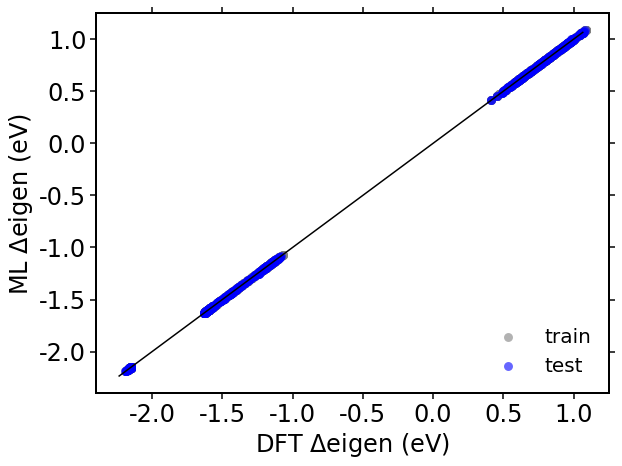

(12480, 16)
(12480,)
random seed 73
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(9984,) (2496,)
0 RMSE 0.0017878282730014155
0 MAE 0.0011030164858504992
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(9984,) (2496,)
1 RMSE 0.0005216998883936003
1 MAE 0.00021943046243698443
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.01}
(9984,) (2496,)
2 RMSE 0.0006281117209103236
2 MAE 0.00015021975609419834
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-05, 'gamma': 0.1}
(9984,) (2496,)
3 RMSE 0.00038653020828835813
3 MAE 7.44240589917168e-05
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 1.0}
(9984,) (2496,)
4 RMSE 0.00018647633420563832
4 MAE 1.8378361527302936e-05
best parameters gamma: 1.0 alpha: 1e-07
('MAE TRAIN ERROR', 5.871762912668622e-08)
('MAE TEST ERROR', 1.8378361527302936e-05)


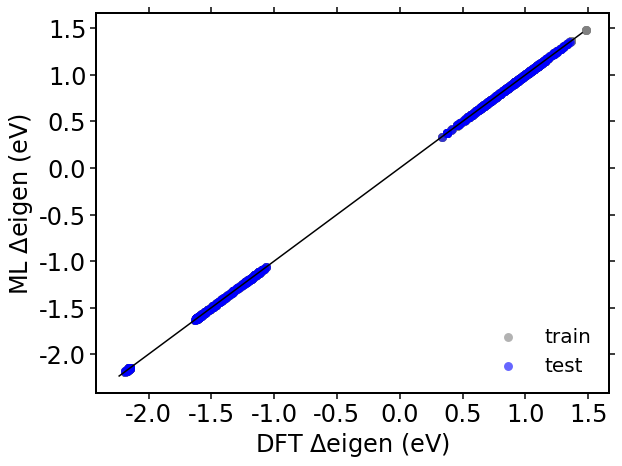

(12480, 16)
(12480,)
random seed 287
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(9984,) (2496,)
0 RMSE 0.00324894542530031
0 MAE 0.00043878418835927735
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(9984,) (2496,)
1 RMSE 0.0033138659052359847
1 MAE 0.000218554138550373
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.01}
(9984,) (2496,)
2 RMSE 0.0031181376999698295
2 MAE 0.00015812385338363923
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.1}
(9984,) (2496,)
3 RMSE 0.0015433785620280465
3 MAE 7.858509180097416e-05
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 1.0}
(9984,) (2496,)
4 RMSE 0.001078176534270926
4 MAE 5.690624594644516e-05
best parameters gamma: 1.0 alpha: 1e-07
('MAE TRAIN ERROR', 2.2841195855589033e-06)
('MAE TEST ERROR', 5.690624594644516e-05)


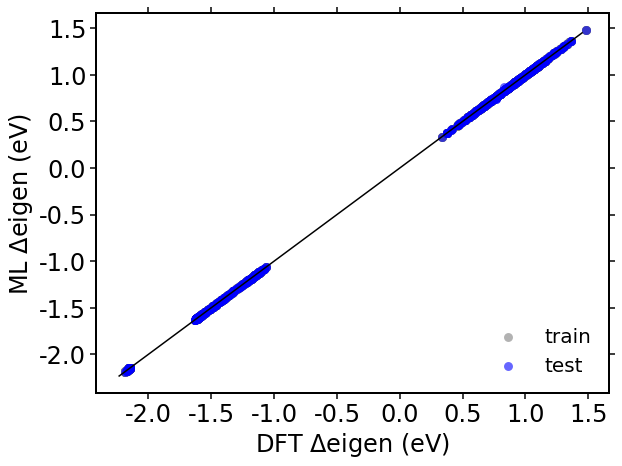

(7616, 16)
(7616,)
random seed 570
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(6092,) (1524,)
0 RMSE 0.013076231384140793
0 MAE 0.0064566441998405435
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(6092,) (1524,)
1 RMSE 0.007664089056580573
1 MAE 0.0019071162656820891
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.01}
(6092,) (1524,)
2 RMSE 0.004422460770412917
2 MAE 0.0008646453220593725
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.1}
(6092,) (1524,)
3 RMSE 0.004843427468045288
3 MAE 0.0008967233012678105
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 1.0}
(6092,) (1524,)
4 RMSE 0.007471425064266983
4 MAE 0.0011961365857301553
best parameters gamma: 0.01 alpha: 1e-07
('MAE TRAIN ERROR', 0.0002197828227024168)
('MAE TEST ERROR', 0.0008646453220593725)


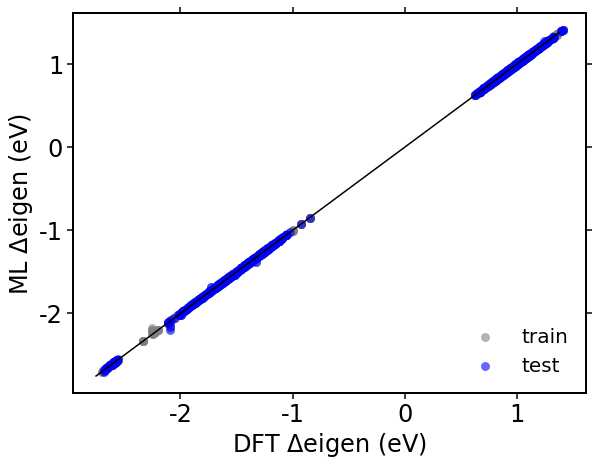

(7616, 16)
(7616,)
random seed 79
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(6092,) (1524,)
0 RMSE 0.09178603110858412
0 MAE 0.051453387856463556
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.001}
(6092,) (1524,)
1 RMSE 0.08645784330759936
1 MAE 0.04897946492597691
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-05, 'gamma': 0.01}
(6092,) (1524,)
2 RMSE 0.08163749230294436
2 MAE 0.045745633909924276
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.0001, 'gamma': 0.1}
(6092,) (1524,)
3 RMSE 0.07877787154457916
3 MAE 0.04276363864728936
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.001, 'gamma': 1.0}
(6092,) (1524,)
4 RMSE 0.07516381803233191
4 MAE 0.04085746597605941
best parameters gamma: 1.0 alpha: 0.001
('MAE TRAIN ERROR', 0.005306381471792988)
('MAE TEST ERROR', 0.04085746597605941)


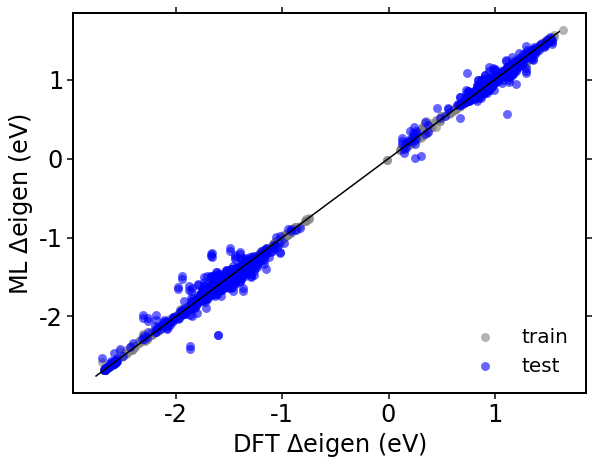

(6048, 16)
(6048,)
random seed 149
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(4838,) (1210,)
0 RMSE 0.01450416128057233
0 MAE 0.005939637762172578
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.001}
(4838,) (1210,)
1 RMSE 0.013105181170253902
1 MAE 0.005763514801516834
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-05, 'gamma': 0.01}
(4838,) (1210,)
2 RMSE 0.011731034710074075
2 MAE 0.005314679820893873
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.0001, 'gamma': 0.1}
(4838,) (1210,)
3 RMSE 0.012370896945071255
3 MAE 0.004682754602172635
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.001, 'gamma': 1.0}
(4838,) (1210,)
4 RMSE 0.012831946790518965
4 MAE 0.003648307395653851
best parameters gamma: 1.0 alpha: 0.001
('MAE TRAIN ERROR', 0.000939490237463583)
('MAE TEST ERROR', 0.003648307395653851)


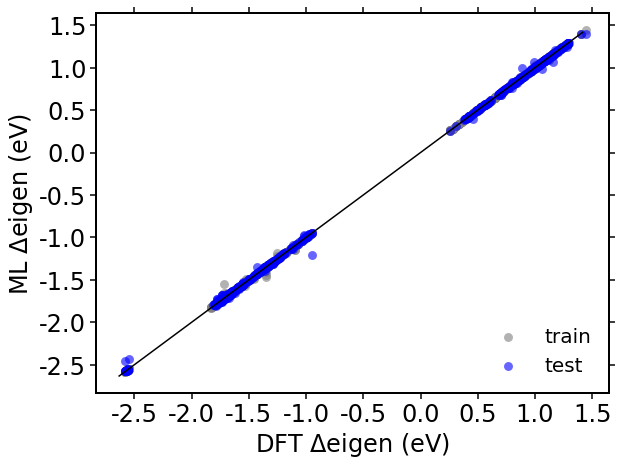

(9504, 16)
(9504,)
random seed 73
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(7603,) (1901,)
0 RMSE 0.1028386605238633
0 MAE 0.050249992360577415
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(7603,) (1901,)
1 RMSE 0.07912926290861765
1 MAE 0.034455883953175774
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.01}
(7603,) (1901,)
2 RMSE 0.0736828835812
2 MAE 0.03190690709224934
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.1}
(7603,) (1901,)
3 RMSE 0.08553645165164916
3 MAE 0.0375460427571667
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.001, 'gamma': 1.0}
(7603,) (1901,)
4 RMSE 0.11136115057236128
4 MAE 0.047421926741472845
best parameters gamma: 0.01 alpha: 1e-07
('MAE TRAIN ERROR', 0.0006964353134725892)
('MAE TEST ERROR', 0.03190690709224934)


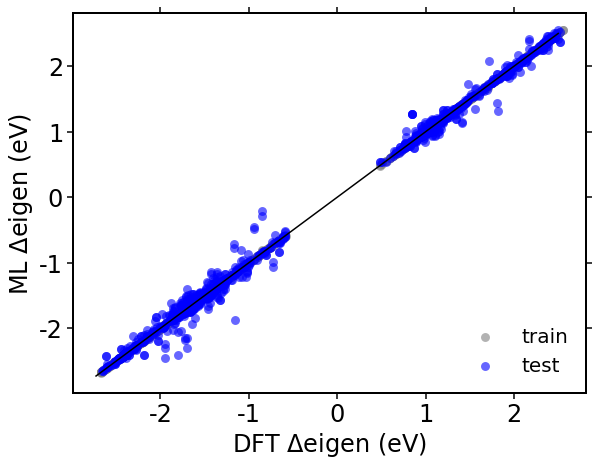

(6120, 16)
(6120,)
random seed 287
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(4896,) (1224,)
0 RMSE 0.08026180368784841
0 MAE 0.03382492565948788
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(4896,) (1224,)
1 RMSE 0.06801345987563978
1 MAE 0.024231165409802264
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.01}
(4896,) (1224,)
2 RMSE 0.07062970788457881
2 MAE 0.02697590203853019
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.1}
(4896,) (1224,)
3 RMSE 0.08212222888827593
3 MAE 0.03550924969057471
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.01, 'gamma': 1.0}
(4896,) (1224,)
4 RMSE 0.091174006867539
4 MAE 0.04560969619296094
best parameters gamma: 0.001 alpha: 1e-07
('MAE TRAIN ERROR', 0.004096180968739197)
('MAE TEST ERROR', 0.024231165409802264)


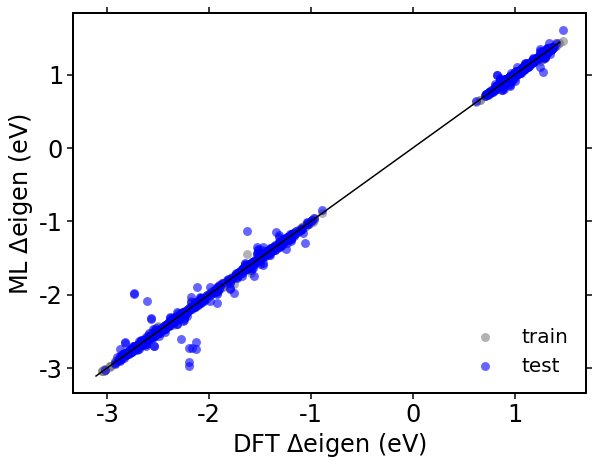

(5200, 16)
(5200,)
random seed 570
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(4160,) (1040,)
0 RMSE 0.016880778502291135
0 MAE 0.0013090131068964348
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.001}
(4160,) (1040,)
1 RMSE 0.013295020777506448
1 MAE 0.0009892155180988031
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-05, 'gamma': 0.01}
(4160,) (1040,)
2 RMSE 0.009226200557189167
2 MAE 0.0007948486317610485
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.0001, 'gamma': 0.1}
(4160,) (1040,)
3 RMSE 0.010567229563256654
3 MAE 0.0007502724333350769
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 1.0}
(4160,) (1040,)
4 RMSE 0.021808777397527616
4 MAE 0.0012983960261594616
best parameters gamma: 0.1 alpha: 0.0001
('MAE TRAIN ERROR', 0.00010823237179619854)
('MAE TEST ERROR', 0.0007502724333350769)


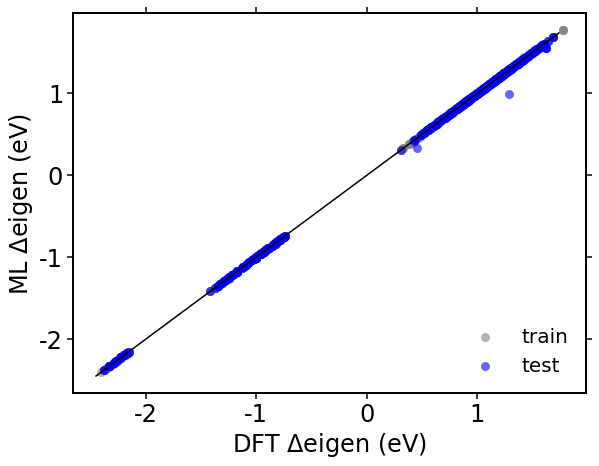

(5200, 16)
(5200,)
random seed 79
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(4160,) (1040,)
0 RMSE 0.0021999337988147173
0 MAE 0.00034602221608334954
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.001}
(4160,) (1040,)
1 RMSE 0.0017186860064076206
1 MAE 0.0003040308588753789
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-05, 'gamma': 0.01}
(4160,) (1040,)
2 RMSE 0.0009811311876399638
2 MAE 0.0002082014422218204
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.1}
(4160,) (1040,)
3 RMSE 0.0027337162742320934
3 MAE 0.00012400245122301775
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.0001, 'gamma': 1.0}
(4160,) (1040,)
4 RMSE 0.01244235100234381
4 MAE 0.0004224967972940768
best parameters gamma: 0.1 alpha: 1e-06
('MAE TRAIN ERROR', 1.3066017674946108e-05)
('MAE TEST ERROR', 0.00012400245122301775)


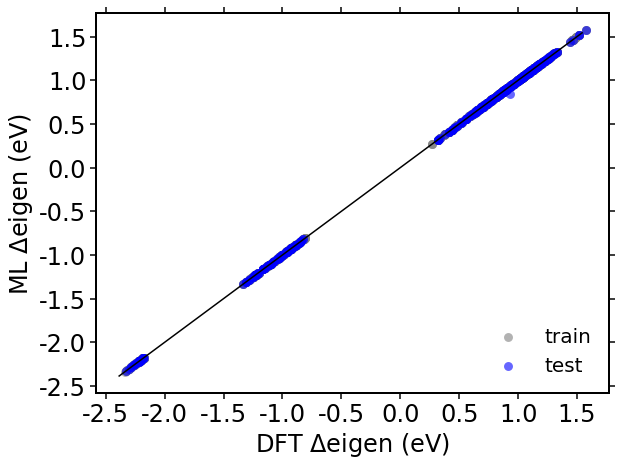

(3696, 16)
(3696,)
random seed 149
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(2956,) (740,)
0 RMSE 0.00845819401058403
0 MAE 0.004629415151542802
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(2956,) (740,)
1 RMSE 0.005979783873299967
1 MAE 0.0021276951981620317
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.01}
(2956,) (740,)
2 RMSE 0.006712987635453338
2 MAE 0.001743634375193125
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.0001, 'gamma': 0.1}
(2956,) (740,)
3 RMSE 0.006040661663326556
3 MAE 0.0021094030263652144
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 1.0}
(2956,) (740,)
4 RMSE 0.0033397708293434318
4 MAE 0.0008716755143360593
best parameters gamma: 1.0 alpha: 1e-07
('MAE TRAIN ERROR', 2.1479247564308486e-06)
('MAE TEST ERROR', 0.0008716755143360593)


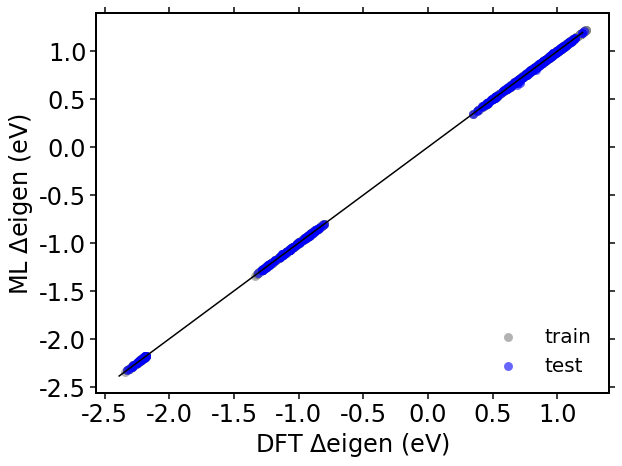

(5200, 16)
(5200,)
random seed 73
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(4160,) (1040,)
0 RMSE 0.007433420766223102
0 MAE 0.0011872481190166552
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(4160,) (1040,)
1 RMSE 0.007222754483487931
1 MAE 0.0007727111368455056
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.01}
(4160,) (1040,)
2 RMSE 0.006810152273231628
2 MAE 0.0007009479816038876
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.1}
(4160,) (1040,)
3 RMSE 0.004660304737932078
3 MAE 0.0004564825453195348
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 1.0}
(4160,) (1040,)
4 RMSE 0.003885809489078282
4 MAE 0.00032078712885744376
best parameters gamma: 1.0 alpha: 1e-06
('MAE TRAIN ERROR', 2.6190756931907952e-05)
('MAE TEST ERROR', 0.00032078712885744376)


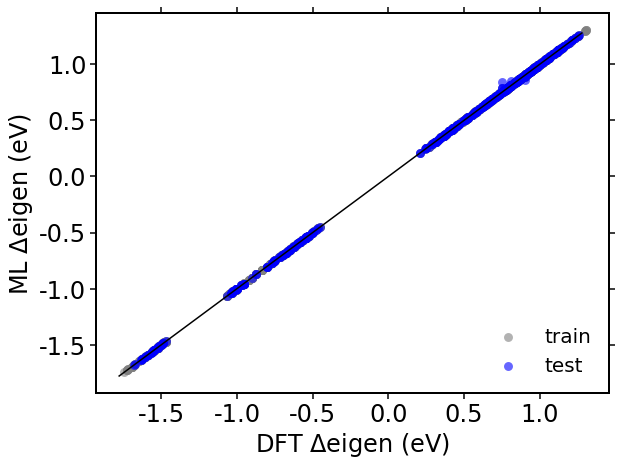

(3168, 16)
(3168,)
random seed 287
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(2534,) (634,)
0 RMSE 0.04853930171699347
0 MAE 0.0123043063431522
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.001}
(2534,) (634,)
1 RMSE 0.04638099832465433
1 MAE 0.011501084178529367
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-05, 'gamma': 0.01}
(2534,) (634,)
2 RMSE 0.04428271854792124
2 MAE 0.010438386365027306
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.1}
(2534,) (634,)
3 RMSE 0.04167183456428348
3 MAE 0.008455612973000548
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 1.0}
(2534,) (634,)
4 RMSE 0.038772651720979615
4 MAE 0.008604958724276485
best parameters gamma: 0.1 alpha: 1e-07
('MAE TRAIN ERROR', 1.098782867201434e-06)
('MAE TEST ERROR', 0.008455612973000548)


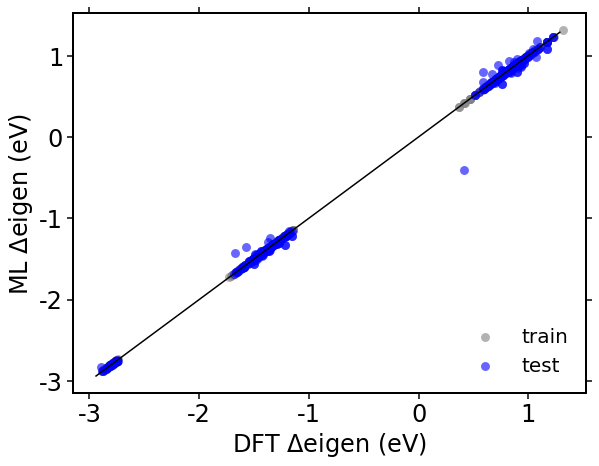

(3328, 16)
(3328,)
random seed 570
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(2662,) (666,)
0 RMSE 0.01744032968172605
0 MAE 0.0094353969685361
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.001}
(2662,) (666,)
1 RMSE 0.016791291644877655
1 MAE 0.00920790205077691
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-05, 'gamma': 0.01}
(2662,) (666,)
2 RMSE 0.01623502055428924
2 MAE 0.008885028574235456
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.0001, 'gamma': 0.1}
(2662,) (666,)
3 RMSE 0.016219620798169698
3 MAE 0.008419654594017657
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.01, 'gamma': 1.0}
(2662,) (666,)
4 RMSE 0.01773758183981349
4 MAE 0.009946404504387222
best parameters gamma: 0.1 alpha: 0.0001
('MAE TRAIN ERROR', 0.0013503265669611816)
('MAE TEST ERROR', 0.008419654594017657)


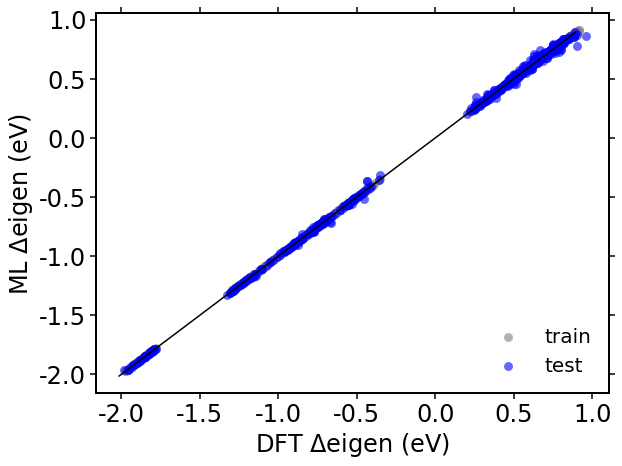

(3848, 16)
(3848,)
random seed 79
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(3078,) (770,)
0 RMSE 0.013621594496954898
0 MAE 0.007436450808866659
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.001}
(3078,) (770,)
1 RMSE 0.01345551038533126
1 MAE 0.007396121460611477
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.0001, 'gamma': 0.01}
(3078,) (770,)
2 RMSE 0.013471126434424122
2 MAE 0.008877099684546606
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.001, 'gamma': 0.1}
(3078,) (770,)
3 RMSE 0.013008759030120064
3 MAE 0.008501299720824031
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.01, 'gamma': 1.0}
(3078,) (770,)
4 RMSE 0.012758548961350863
4 MAE 0.00799428670277784
best parameters gamma: 0.001 alpha: 1e-06
('MAE TRAIN ERROR', 0.002580552979635469)
('MAE TEST ERROR', 0.007396121460611477)


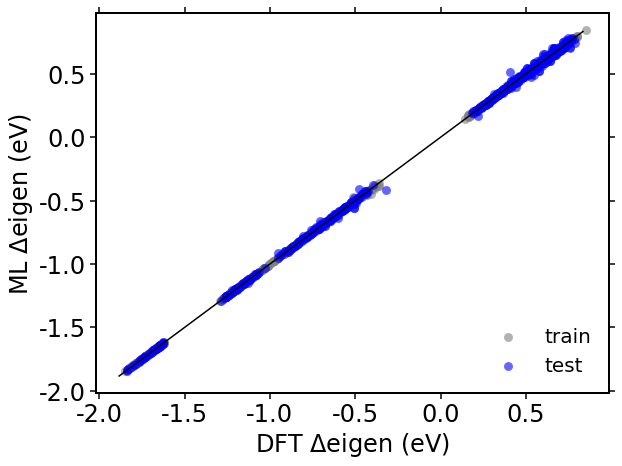

(3696, 16)
(3696,)
random seed 149
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(2956,) (740,)
0 RMSE 0.018496429778062543
0 MAE 0.00406100982912271
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(2956,) (740,)
1 RMSE 0.01724961562958759
1 MAE 0.0022674918544509995
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.01}
(2956,) (740,)
2 RMSE 0.014621796194504195
2 MAE 0.0018310565864253065
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.1}
(2956,) (740,)
3 RMSE 0.010355891000955693
3 MAE 0.0016165763479832674
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 1.0}
(2956,) (740,)
4 RMSE 0.017033766072981116
4 MAE 0.0021300495294248292
best parameters gamma: 0.1 alpha: 1e-06
('MAE TRAIN ERROR', 1.564292563526491e-05)
('MAE TEST ERROR', 0.0016165763479832674)


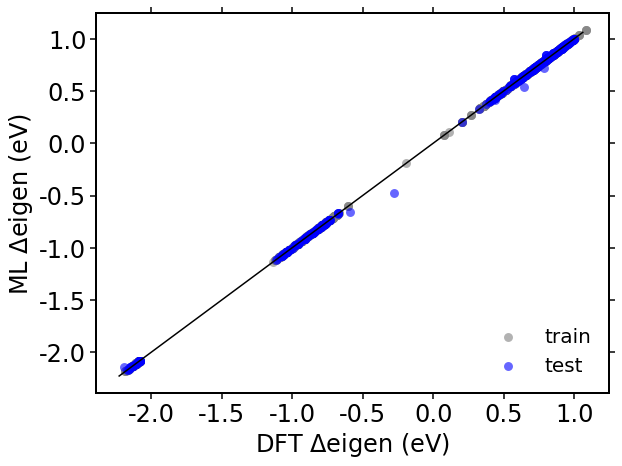

(5200, 16)
(5200,)
random seed 73
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(4160,) (1040,)
0 RMSE 0.004590260452261833
0 MAE 0.0005660041797527631
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.001}
(4160,) (1040,)
1 RMSE 0.004250713655019154
1 MAE 0.0005338932008906505
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-05, 'gamma': 0.01}
(4160,) (1040,)
2 RMSE 0.0034313405798645454
2 MAE 0.00042123741004156687
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.1}
(4160,) (1040,)
3 RMSE 0.0010691260285437814
3 MAE 7.48369923156646e-05
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 1.0}
(4160,) (1040,)
4 RMSE 0.0036249524947112397
4 MAE 0.0001556610473322931
best parameters gamma: 0.1 alpha: 1e-07
('MAE TRAIN ERROR', 3.2249896753634114e-05)
('MAE TEST ERROR', 7.48369923156646e-05)


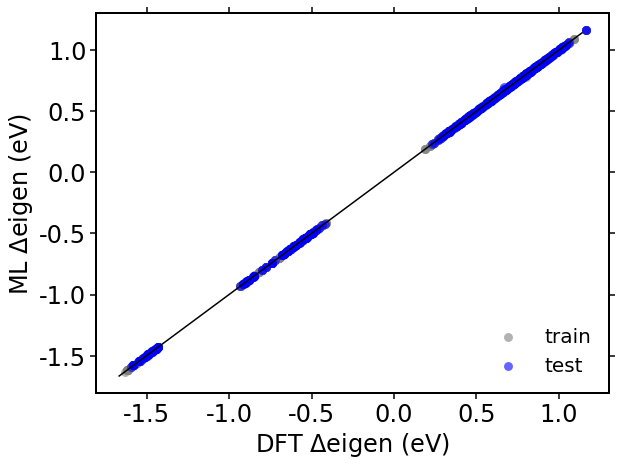

(3584, 16)
(3584,)
random seed 287
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(2867,) (717,)
0 RMSE 0.011571965000681547
0 MAE 0.003735887590288274
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(2867,) (717,)
1 RMSE 0.011073218373355277
1 MAE 0.0026193195963742457
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.01}
(2867,) (717,)
2 RMSE 0.010504935031483314
2 MAE 0.0022192664969091632
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.1}
(2867,) (717,)
3 RMSE 0.010016822096658927
3 MAE 0.0019432147842537626
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 1.0}
(2867,) (717,)
4 RMSE 0.0097025111460397
4 MAE 0.0018019341043950783
best parameters gamma: 1.0 alpha: 1e-07
('MAE TRAIN ERROR', 3.950440994972967e-06)
('MAE TEST ERROR', 0.0018019341043950783)


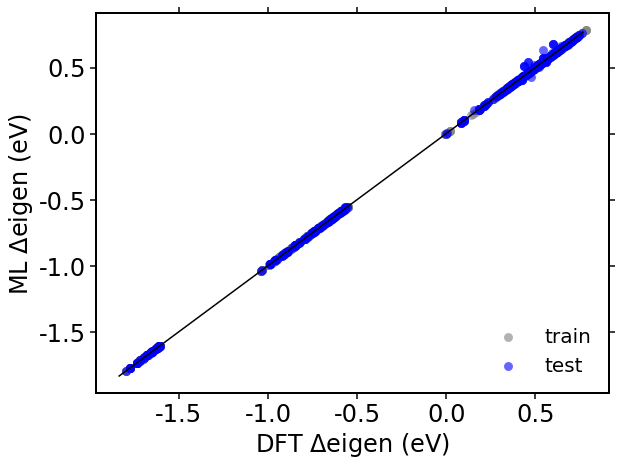

(4680, 16)
(4680,)
random seed 570
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(3744,) (936,)
0 RMSE 0.00482884619633072
0 MAE 0.0006950513234872576
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(3744,) (936,)
1 RMSE 0.004455595339516648
1 MAE 0.00026441677822573164
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.01}
(3744,) (936,)
2 RMSE 0.0044536530695622
2 MAE 0.0002552403366981063
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.0001, 'gamma': 0.1}
(3744,) (936,)
3 RMSE 0.0045586414314130715
3 MAE 0.00042714013324809117
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 1.0}
(3744,) (936,)
4 RMSE 0.002197370373236415
4 MAE 0.00010406787553923454
best parameters gamma: 1.0 alpha: 1e-06
('MAE TRAIN ERROR', 6.037471335242872e-05)
('MAE TEST ERROR', 0.00010406787553923454)


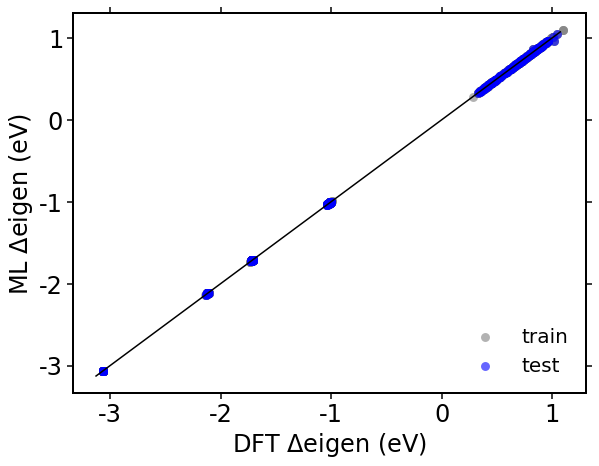

(5120, 16)
(5120,)
random seed 79
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(4096,) (1024,)
0 RMSE 0.04970350028430589
0 MAE 0.02884060736462613
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(4096,) (1024,)
1 RMSE 0.04510842000135545
1 MAE 0.022666459532338777
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.01}
(4096,) (1024,)
2 RMSE 0.04691426744223274
2 MAE 0.0252106439675503
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.0001, 'gamma': 0.1}
(4096,) (1024,)
3 RMSE 0.05282854519880346
3 MAE 0.03144253201123908
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.01, 'gamma': 1.0}
(4096,) (1024,)
4 RMSE 0.05734099746932699
4 MAE 0.03524107032158052
best parameters gamma: 0.001 alpha: 1e-07
('MAE TRAIN ERROR', 0.0034027121430452944)
('MAE TEST ERROR', 0.022666459532338777)


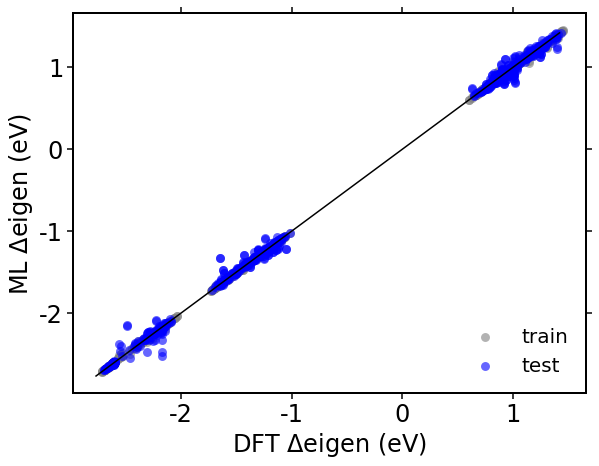

(4160, 16)
(4160,)
random seed 149
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(3328,) (832,)
0 RMSE 0.012395929391508024
0 MAE 0.0012567668127954448
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(3328,) (832,)
1 RMSE 0.011672016864947855
1 MAE 0.0010097004428800125
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.01}
(3328,) (832,)
2 RMSE 0.008555329928145266
2 MAE 0.0007115747853764336
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.1}
(3328,) (832,)
3 RMSE 0.005012648035805721
3 MAE 0.0003605540211385224
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 1.0}
(3328,) (832,)
4 RMSE 0.021405064443751513
4 MAE 0.0014431151658197542
best parameters gamma: 0.1 alpha: 1e-07
('MAE TRAIN ERROR', 2.6641865112944414e-05)
('MAE TEST ERROR', 0.0003605540211385224)


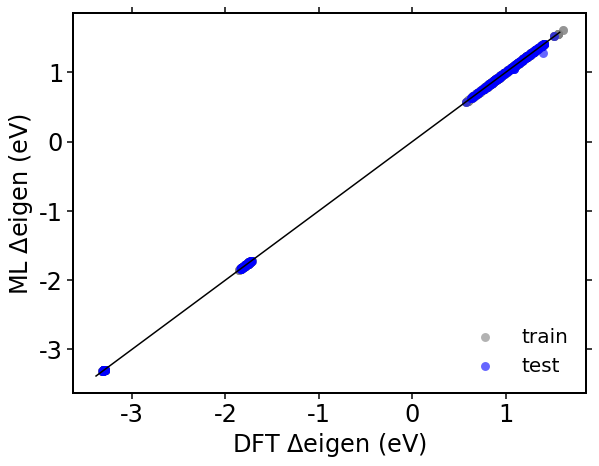

(2752, 16)
(2752,)
random seed 73
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(2201,) (551,)
0 RMSE 0.009400003206155352
0 MAE 0.0009410796607182712
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(2201,) (551,)
1 RMSE 0.008340161027238604
1 MAE 0.0007181346803258806
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.01}
(2201,) (551,)
2 RMSE 0.0048172329983415425
2 MAE 0.0004291213440432035
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.1}
(2201,) (551,)
3 RMSE 0.0027308723902670943
3 MAE 0.00027291657501940075
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 1.0}
(2201,) (551,)
4 RMSE 0.007181504606865642
4 MAE 0.0006345165480604178
best parameters gamma: 0.1 alpha: 1e-07
('MAE TRAIN ERROR', 1.906056072830905e-05)
('MAE TEST ERROR', 0.00027291657501940075)


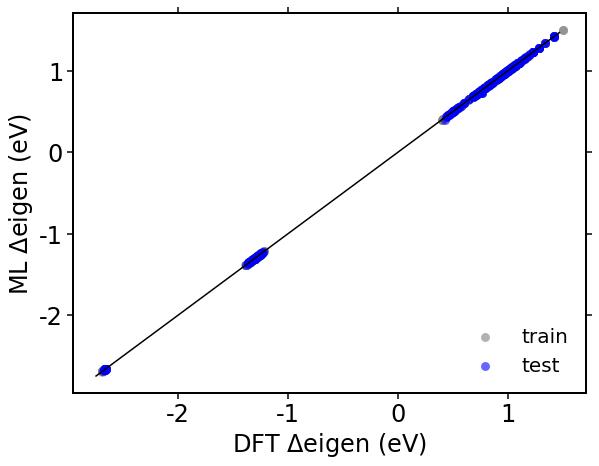

(2664, 16)
(2664,)
random seed 287
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(2131,) (533,)
0 RMSE 0.017855164656097933
0 MAE 0.0036893827861577888
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.001}
(2131,) (533,)
1 RMSE 0.01763315808815221
1 MAE 0.0034984913461541295
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-05, 'gamma': 0.01}
(2131,) (533,)
2 RMSE 0.016066830330469774
2 MAE 0.0031251172743755693
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.0001, 'gamma': 0.1}
(2131,) (533,)
3 RMSE 0.01383167162316177
3 MAE 0.002330895128788054
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.001, 'gamma': 1.0}
(2131,) (533,)
4 RMSE 0.011381523735942409
4 MAE 0.001695488607935498
best parameters gamma: 1.0 alpha: 0.001
('MAE TRAIN ERROR', 0.00023143453292411218)
('MAE TEST ERROR', 0.001695488607935498)


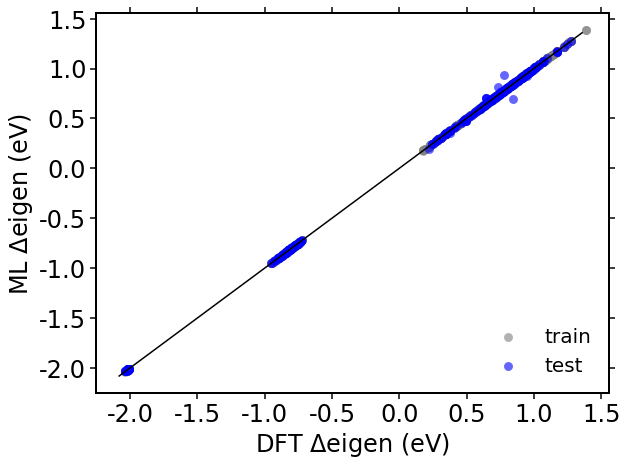

(4536, 16)
(4536,)
random seed 570
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(3628,) (908,)
0 RMSE 0.013050976117319242
0 MAE 0.001987049460481449
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.001}
(3628,) (908,)
1 RMSE 0.011537035263959477
1 MAE 0.001794958781433116
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-05, 'gamma': 0.01}
(3628,) (908,)
2 RMSE 0.01016635084279043
2 MAE 0.0016152581012291228
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.0001, 'gamma': 0.1}
(3628,) (908,)
3 RMSE 0.009838019521770403
3 MAE 0.0014105566216329425
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.001, 'gamma': 1.0}
(3628,) (908,)
4 RMSE 0.009091047915230775
4 MAE 0.001275354027885699
best parameters gamma: 1.0 alpha: 0.001
('MAE TRAIN ERROR', 0.0002810288602231752)
('MAE TEST ERROR', 0.001275354027885699)


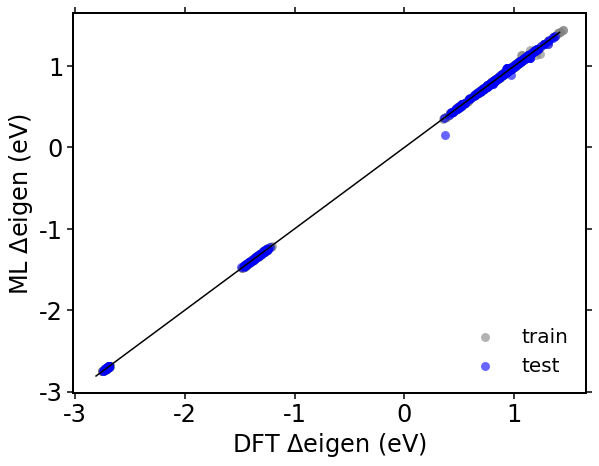

(3696, 16)
(3696,)
random seed 79
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(2956,) (740,)
0 RMSE 0.014124046179421635
0 MAE 0.004652752191739295
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.001}
(2956,) (740,)
1 RMSE 0.013390423057308809
1 MAE 0.004269704740143637
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-05, 'gamma': 0.01}
(2956,) (740,)
2 RMSE 0.012257161606514083
2 MAE 0.003665395646685583
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.0001, 'gamma': 0.1}
(2956,) (740,)
3 RMSE 0.010550542161274011
3 MAE 0.0026237202935539684
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 1.0}
(2956,) (740,)
4 RMSE 0.016081796475503493
4 MAE 0.002391185210778398
best parameters gamma: 1.0 alpha: 1e-07
('MAE TRAIN ERROR', 5.412247202641127e-06)
('MAE TEST ERROR', 0.002391185210778398)


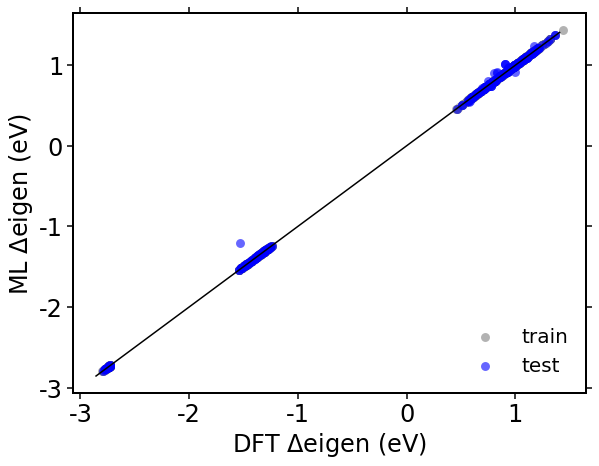

(4680, 16)
(4680,)
random seed 149
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(3744,) (936,)
0 RMSE 0.016511573634324365
0 MAE 0.0012408676946833344
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(3744,) (936,)
1 RMSE 0.015003231995128421
1 MAE 0.0010321340031851413
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.01}
(3744,) (936,)
2 RMSE 0.012155848986034732
2 MAE 0.0008352743793072802
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-05, 'gamma': 0.1}
(3744,) (936,)
3 RMSE 0.00999593659412614
3 MAE 0.0007052066171621238
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 1.0}
(3744,) (936,)
4 RMSE 0.023186072353106827
4 MAE 0.0022535091634241287
best parameters gamma: 0.1 alpha: 1e-05
('MAE TRAIN ERROR', 9.505929753073428e-06)
('MAE TEST ERROR', 0.0007052066171621238)


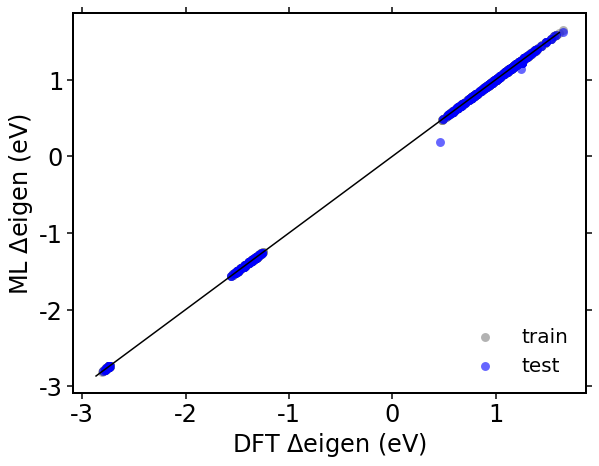

(4680, 16)
(4680,)
random seed 73
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(3744,) (936,)
0 RMSE 0.01585723826431202
0 MAE 0.0006679873201171586
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.001}
(3744,) (936,)
1 RMSE 0.01432843958466402
1 MAE 0.0006065137696723241
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.01}
(3744,) (936,)
2 RMSE 0.011654727362332919
2 MAE 0.00042819965978730474
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.1}
(3744,) (936,)
3 RMSE 0.00930370009744717
3 MAE 0.0003289130435703552
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 1.0}
(3744,) (936,)
4 RMSE 0.007846997315467955
4 MAE 0.0002699519248534679
best parameters gamma: 1.0 alpha: 1e-07
('MAE TRAIN ERROR', 1.2383083410924575e-05)
('MAE TEST ERROR', 0.0002699519248534679)


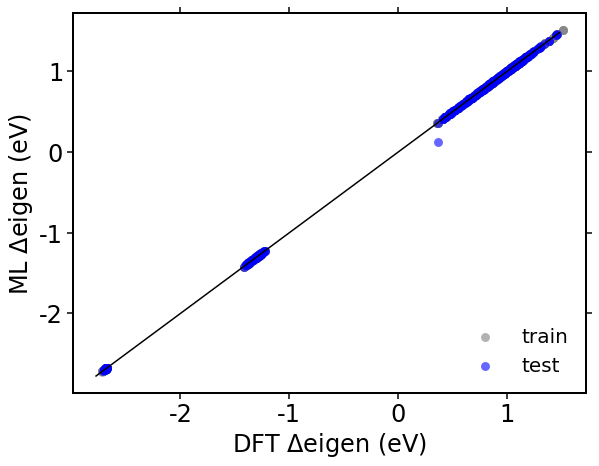

(3696, 16)
(3696,)
random seed 287
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(2956,) (740,)
0 RMSE 0.011406947670483922
0 MAE 0.0033782941026651255
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(2956,) (740,)
1 RMSE 0.010882204920303397
1 MAE 0.0017285311986513226
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.01}
(2956,) (740,)
2 RMSE 0.01010855340835765
2 MAE 0.0015712091166971939
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.1}
(2956,) (740,)
3 RMSE 0.008907835824521041
3 MAE 0.0019513190869237796
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-05, 'gamma': 1.0}
(2956,) (740,)
4 RMSE 0.009583115512323501
4 MAE 0.00202280156470144
best parameters gamma: 0.01 alpha: 1e-07
('MAE TRAIN ERROR', 4.585035077188968e-05)
('MAE TEST ERROR', 0.0015712091166971939)


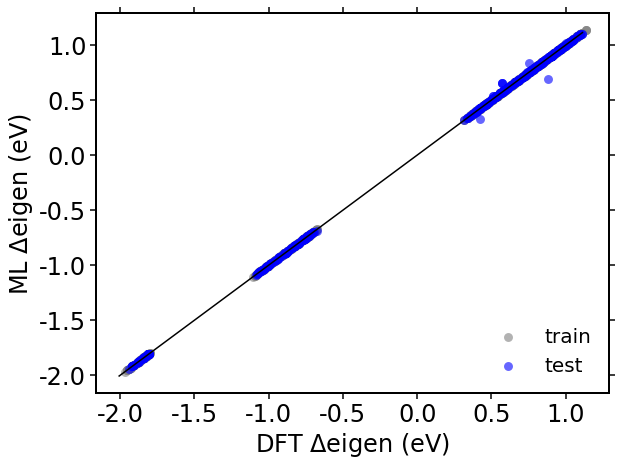

(4680, 16)
(4680,)
random seed 570
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(3744,) (936,)
0 RMSE 0.005667435634990451
0 MAE 0.00046697919178904994
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.001}
(3744,) (936,)
1 RMSE 0.006258941289675847
1 MAE 0.0004707415534791025
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-05, 'gamma': 0.01}
(3744,) (936,)
2 RMSE 0.007781238937832602
2 MAE 0.00047290741041559
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.0001, 'gamma': 0.1}
(3744,) (936,)
3 RMSE 0.008900220145235702
3 MAE 0.00041993088692322464
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.001, 'gamma': 1.0}
(3744,) (936,)
4 RMSE 0.008752235743902506
4 MAE 0.00035840649675395006
best parameters gamma: 1.0 alpha: 0.001
('MAE TRAIN ERROR', 0.00016876101496263675)
('MAE TEST ERROR', 0.00035840649675395006)


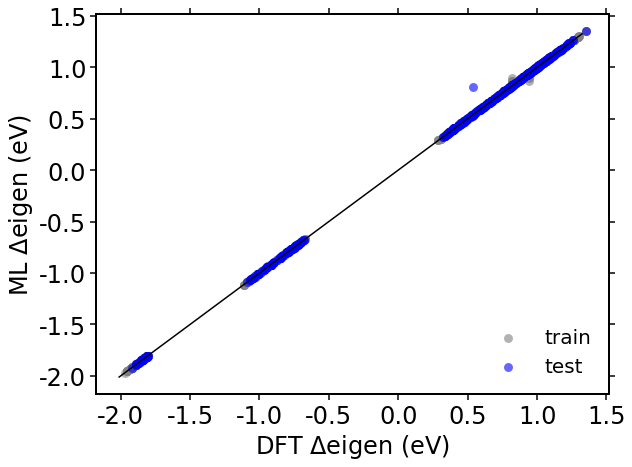

(3696, 16)
(3696,)
random seed 79
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(2956,) (740,)
0 RMSE 0.009354681882954128
0 MAE 0.0038307049697423497
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(2956,) (740,)
1 RMSE 0.00828566408393039
1 MAE 0.0018474001491979798
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.01}
(2956,) (740,)
2 RMSE 0.008203315950856266
2 MAE 0.0014233820858297467
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-05, 'gamma': 0.1}
(2956,) (740,)
3 RMSE 0.007689688800195135
3 MAE 0.0019675610946954507
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 1.0}
(2956,) (740,)
4 RMSE 0.0070167235555520695
4 MAE 0.0020488837268365996
best parameters gamma: 0.01 alpha: 1e-07
('MAE TRAIN ERROR', 6.956134968569218e-05)
('MAE TEST ERROR', 0.0014233820858297467)


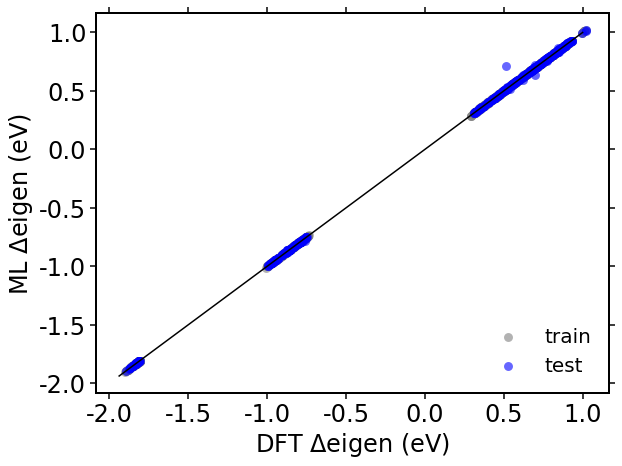

(4680, 16)
(4680,)
random seed 149
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(3744,) (936,)
0 RMSE 0.01721073592332448
0 MAE 0.0011488559955036472
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(3744,) (936,)
1 RMSE 0.015968213010786984
1 MAE 0.000770946004119232
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.01}
(3744,) (936,)
2 RMSE 0.013652838136939132
2 MAE 0.0006246089486906552
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.1}
(3744,) (936,)
3 RMSE 0.011033266014916695
3 MAE 0.00046139617276556714
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 1.0}
(3744,) (936,)
4 RMSE 0.00967945671759375
4 MAE 0.0003997717965613354
best parameters gamma: 1.0 alpha: 1e-07
('MAE TRAIN ERROR', 2.721905934005423e-06)
('MAE TEST ERROR', 0.0003997717965613354)


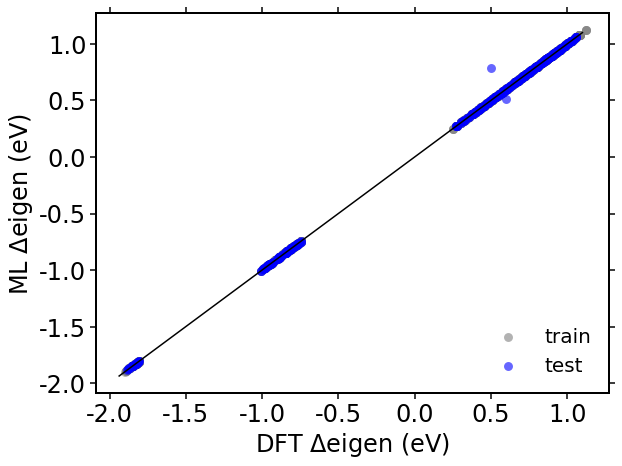

(3696, 16)
(3696,)
random seed 73
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(2956,) (740,)
0 RMSE 0.006221475970752669
0 MAE 0.0026997100139353482
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(2956,) (740,)
1 RMSE 0.006225048150850157
1 MAE 0.0015303904880429023
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.01}
(2956,) (740,)
2 RMSE 0.004743587027613827
2 MAE 0.0012517114400985674
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.1}
(2956,) (740,)
3 RMSE 0.004273231583123114
3 MAE 0.0013060916316560342
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 1.0}
(2956,) (740,)
4 RMSE 0.00444103748810881
4 MAE 0.0012119101698591704
best parameters gamma: 1.0 alpha: 1e-07
('MAE TRAIN ERROR', 7.03774380923612e-07)
('MAE TEST ERROR', 0.0012119101698591704)


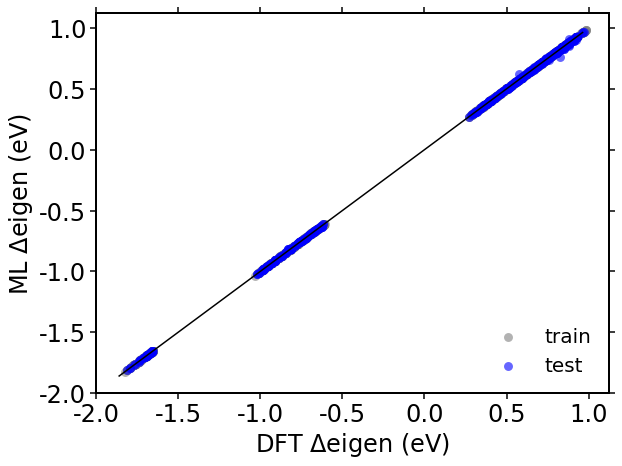

(4680, 16)
(4680,)
random seed 287
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(3744,) (936,)
0 RMSE 0.0025401322232179303
0 MAE 0.0003528901095528146
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(3744,) (936,)
1 RMSE 0.0023327852740137375
1 MAE 0.00015378711941586303
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.01}
(3744,) (936,)
2 RMSE 0.0021864143307003844
2 MAE 0.00013269142136704515
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-05, 'gamma': 0.1}
(3744,) (936,)
3 RMSE 0.0023520879785778387
3 MAE 9.894115452075528e-05
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 1.0}
(3744,) (936,)
4 RMSE 0.006487267894559221
4 MAE 0.0003049277880055166
best parameters gamma: 0.1 alpha: 1e-05
('MAE TRAIN ERROR', 1.470277900112801e-05)
('MAE TEST ERROR', 9.894115452075528e-05)


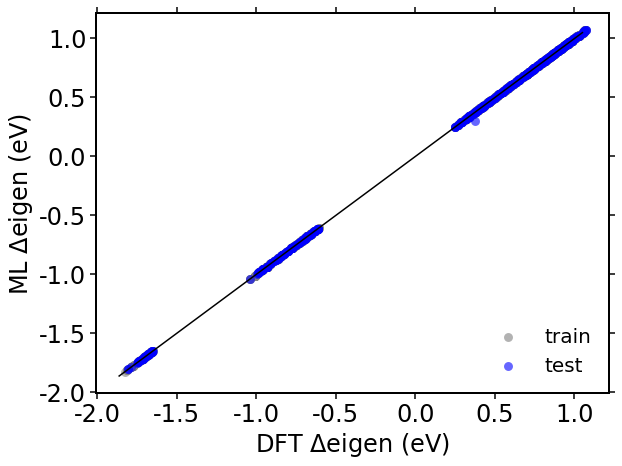

(3696, 16)
(3696,)
random seed 570
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(2956,) (740,)
0 RMSE 0.0061917696633388255
0 MAE 0.002831882800270557
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(2956,) (740,)
1 RMSE 0.005156111032573266
1 MAE 0.001346448421391257
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.01}
(2956,) (740,)
2 RMSE 0.005341786327844827
2 MAE 0.0012121111118740537
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.1}
(2956,) (740,)
3 RMSE 0.006184886515055222
3 MAE 0.0014533549708818341
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 1.0}
(2956,) (740,)
4 RMSE 0.006697585281528283
4 MAE 0.0014837694148484412
best parameters gamma: 0.01 alpha: 1e-07
('MAE TRAIN ERROR', 3.260618151486294e-05)
('MAE TEST ERROR', 0.0012121111118740537)


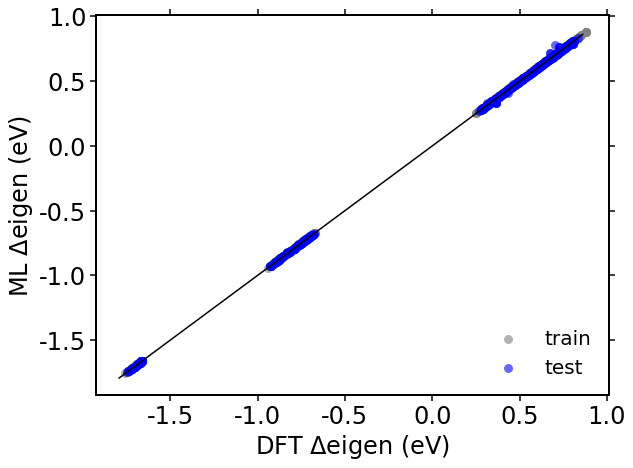

(4680, 16)
(4680,)
random seed 79
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(3744,) (936,)
0 RMSE 0.0005394343712345239
0 MAE 0.0002506584396344613
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(3744,) (936,)
1 RMSE 0.00015343028897073842
1 MAE 3.2751968556621535e-05
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.01}
(3744,) (936,)
2 RMSE 0.0001670295884168345
2 MAE 2.8256709095957264e-05
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.0001, 'gamma': 0.1}
(3744,) (936,)
3 RMSE 0.00023663305386001105
3 MAE 9.273460212216235e-05
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.001, 'gamma': 1.0}
(3744,) (936,)
4 RMSE 0.00012236038506677004
4 MAE 5.3292063823467653e-05
best parameters gamma: 0.01 alpha: 1e-06
('MAE TRAIN ERROR', 1.6205219260454107e-05)
('MAE TEST ERROR', 2.8256709095957264e-05)


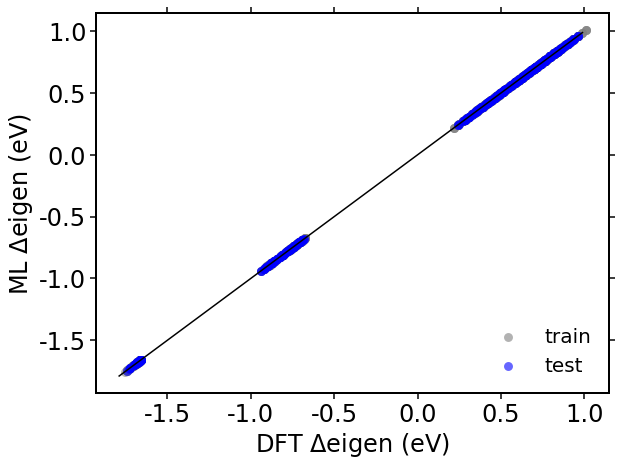

(5832, 16)
(5832,)
random seed 149
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(4665,) (1167,)
0 RMSE 0.011339451774876354
0 MAE 0.0030542739026830205
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(4665,) (1167,)
1 RMSE 0.011221787365792123
1 MAE 0.0017258021705449102
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.01}
(4665,) (1167,)
2 RMSE 0.01095484906149574
2 MAE 0.0012727318893163003
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.1}
(4665,) (1167,)
3 RMSE 0.00968152665405118
3 MAE 0.001037116834562776
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 1.0}
(4665,) (1167,)
4 RMSE 0.009834567875452132
4 MAE 0.0009700754129941607
best parameters gamma: 1.0 alpha: 1e-07
('MAE TRAIN ERROR', 3.060548459318697e-07)
('MAE TEST ERROR', 0.0009700754129941607)


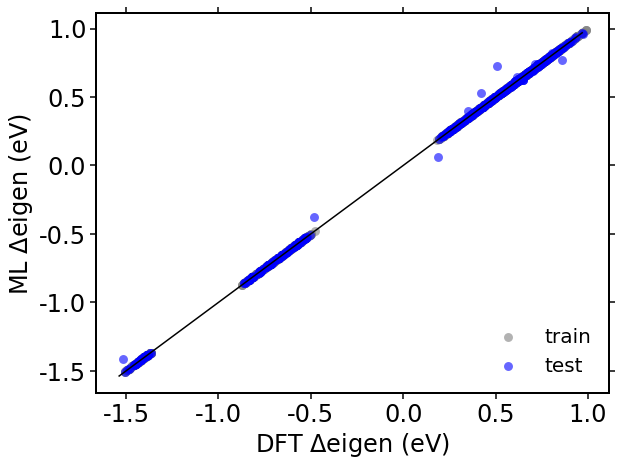

(4752, 16)
(4752,)
random seed 73
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(3801,) (951,)
0 RMSE 0.00888686463941989
0 MAE 0.003325453573090487
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.001}
(3801,) (951,)
1 RMSE 0.009126720612189798
1 MAE 0.0033687756523907517
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-05, 'gamma': 0.01}
(3801,) (951,)
2 RMSE 0.009424648044100856
2 MAE 0.00317958839190279
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-05, 'gamma': 0.1}
(3801,) (951,)
3 RMSE 0.008914335710268163
3 MAE 0.002358385593628321
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 1.0}
(3801,) (951,)
4 RMSE 0.009808356883336585
4 MAE 0.0023923261686101993
best parameters gamma: 0.1 alpha: 1e-05
('MAE TRAIN ERROR', 0.00014818291371252267)
('MAE TEST ERROR', 0.002358385593628321)


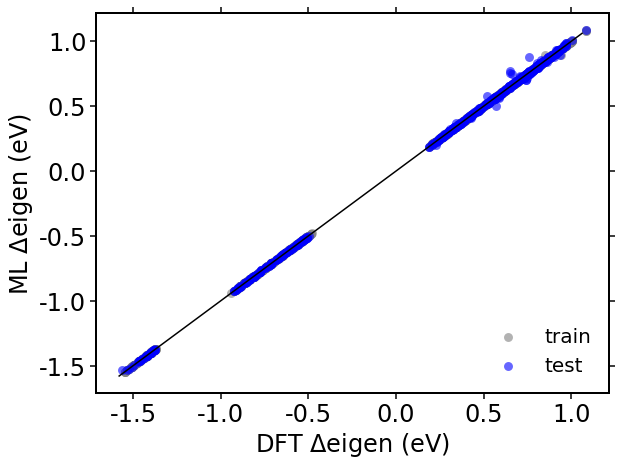

(6240, 16)
(6240,)
random seed 287
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(4992,) (1248,)
0 RMSE 0.0017377089539610071
0 MAE 0.00047849510063506805
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.001}
(4992,) (1248,)
1 RMSE 0.0014737468841075478
1 MAE 0.0004110826498433004
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.01}
(4992,) (1248,)
2 RMSE 0.0008371772498740254
2 MAE 0.00011208184734849226
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-05, 'gamma': 0.1}
(4992,) (1248,)
3 RMSE 0.0013425439191417175
3 MAE 0.00011141852454140064
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.001, 'gamma': 1.0}
(4992,) (1248,)
4 RMSE 0.006407510487822837
4 MAE 0.000346773503165885
best parameters gamma: 0.1 alpha: 1e-05
('MAE TRAIN ERROR', 2.892314440830426e-05)
('MAE TEST ERROR', 0.00011141852454140064)


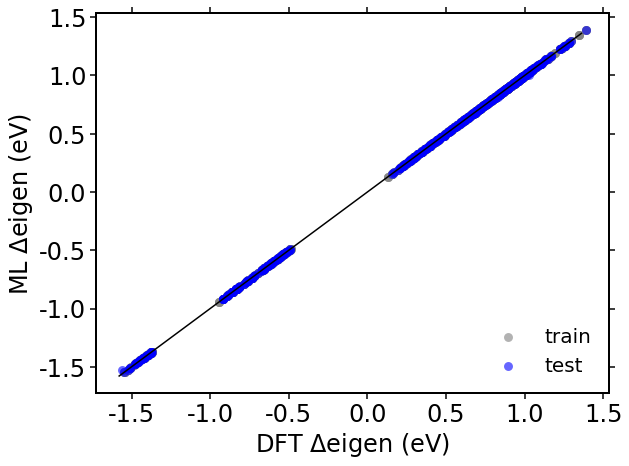

(4752, 16)
(4752,)
random seed 570
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(3801,) (951,)
0 RMSE 0.015411450273047625
0 MAE 0.003988644595149399
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(3801,) (951,)
1 RMSE 0.014811741875776975
1 MAE 0.0020179695232605123
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.01}
(3801,) (951,)
2 RMSE 0.014965558338927288
2 MAE 0.002272020899561342
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-05, 'gamma': 0.1}
(3801,) (951,)
3 RMSE 0.01760775104164737
3 MAE 0.0027736513044951216
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.0001, 'gamma': 1.0}
(3801,) (951,)
4 RMSE 0.027347371142663193
4 MAE 0.00340841178617447
best parameters gamma: 0.001 alpha: 1e-07
('MAE TRAIN ERROR', 0.00039172602310879326)
('MAE TEST ERROR', 0.0020179695232605123)


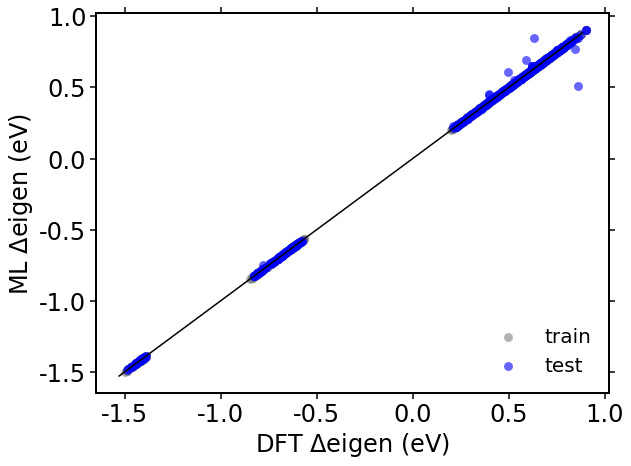

(6240, 16)
(6240,)
random seed 79
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(4992,) (1248,)
0 RMSE 0.0051460592042709115
0 MAE 0.0009034065177026698
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.001}
(4992,) (1248,)
1 RMSE 0.004937867047015632
1 MAE 0.0008586162685603508
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-05, 'gamma': 0.01}
(4992,) (1248,)
2 RMSE 0.0043408856393055495
2 MAE 0.0007244539274439899
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.1}
(4992,) (1248,)
3 RMSE 0.0035089547194304643
3 MAE 0.0002604133936131573
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.001, 'gamma': 1.0}
(4992,) (1248,)
4 RMSE 0.003383687841417839
4 MAE 0.0003701318993199461
best parameters gamma: 0.1 alpha: 1e-07
('MAE TRAIN ERROR', 6.334481601835235e-05)
('MAE TEST ERROR', 0.0002604133936131573)


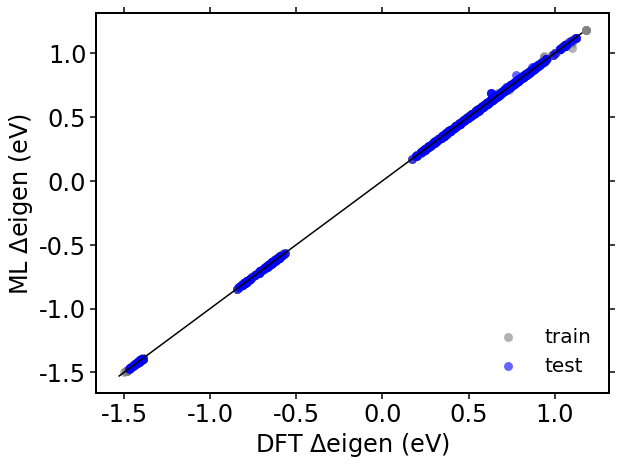

(7384, 16)
(7384,)
random seed 149
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(5907,) (1477,)
0 RMSE 0.03723667074134018
0 MAE 0.021083555128850972
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(5907,) (1477,)
1 RMSE 0.028686817143448985
1 MAE 0.012955057367422557
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.01}
(5907,) (1477,)
2 RMSE 0.03279999757360156
2 MAE 0.014780851012434036
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-05, 'gamma': 0.1}
(5907,) (1477,)
3 RMSE 0.04109576917774822
3 MAE 0.018145125932669107
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.001, 'gamma': 1.0}
(5907,) (1477,)
4 RMSE 0.05471024948033313
4 MAE 0.022309399976989698
best parameters gamma: 0.001 alpha: 1e-07
('MAE TRAIN ERROR', 0.003920548874074206)
('MAE TEST ERROR', 0.012955057367422557)


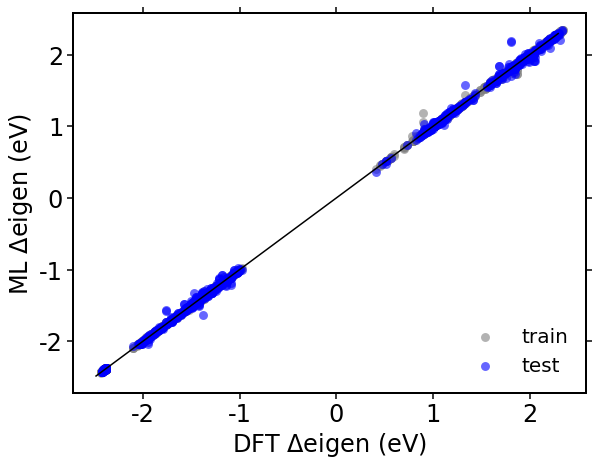

(12544, 16)
(12544,)
random seed 73
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(10035,) (2509,)
0 RMSE 0.029461752198997833
0 MAE 0.01649597403670854
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(10035,) (2509,)
1 RMSE 0.017544825176252887
1 MAE 0.006896279235033547
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.01}
(10035,) (2509,)
2 RMSE 0.02276311584355846
2 MAE 0.0059333721835721255
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.1}
(10035,) (2509,)
3 RMSE 0.030159131682464237
3 MAE 0.007933812338224853
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 1.0}
(10035,) (2509,)
4 RMSE 0.03234005883056059
4 MAE 0.009002749470497881
best parameters gamma: 0.01 alpha: 1e-07
('MAE TRAIN ERROR', 0.00017274405708091428)
('MAE TEST ERROR', 0.0059333721835721255)


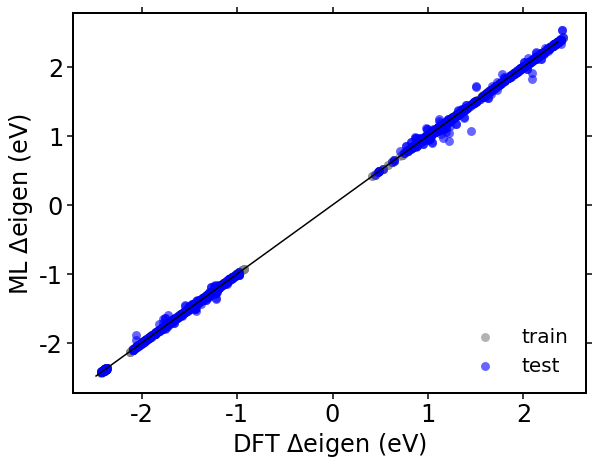

(11008, 16)
(11008,)
random seed 287
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(8806,) (2202,)
0 RMSE 0.01929471926828891
0 MAE 0.005744564155456867
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.001}
(8806,) (2202,)
1 RMSE 0.019403711385903678
1 MAE 0.0055293100458289595
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-05, 'gamma': 0.01}
(8806,) (2202,)
2 RMSE 0.018767743409160594
2 MAE 0.004652763631975074
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.0001, 'gamma': 0.1}
(8806,) (2202,)
3 RMSE 0.017934564378817585
3 MAE 0.0034419231468048876
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.001, 'gamma': 1.0}
(8806,) (2202,)
4 RMSE 0.02050201942477889
4 MAE 0.0027769169097906082
best parameters gamma: 1.0 alpha: 0.001
('MAE TRAIN ERROR', 0.0009062571270418016)
('MAE TEST ERROR', 0.0027769169097906082)


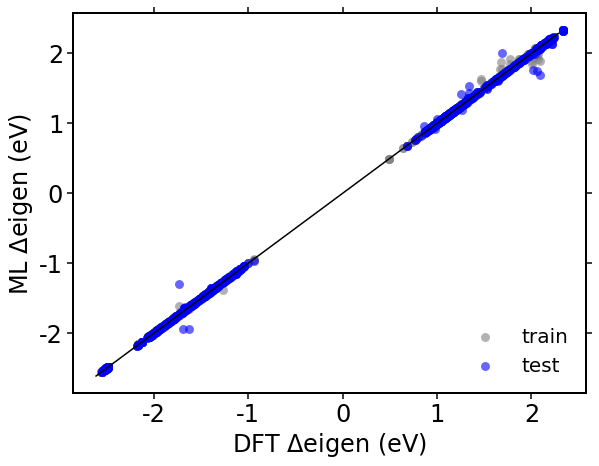

(7040, 16)
(7040,)
random seed 570
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(5632,) (1408,)
0 RMSE 0.07089790116098973
0 MAE 0.028377295176309814
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(5632,) (1408,)
1 RMSE 0.06960487752368855
1 MAE 0.01880621627934692
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.01}
(5632,) (1408,)
2 RMSE 0.07523570312749357
2 MAE 0.01984988824583025
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.0001, 'gamma': 0.1}
(5632,) (1408,)
3 RMSE 0.08524103917455036
3 MAE 0.024200182908562365
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.01, 'gamma': 1.0}
(5632,) (1408,)
4 RMSE 0.10231467623205909
4 MAE 0.03378679963432441
best parameters gamma: 0.001 alpha: 1e-07
('MAE TRAIN ERROR', 0.0021724476887298814)
('MAE TEST ERROR', 0.01880621627934692)


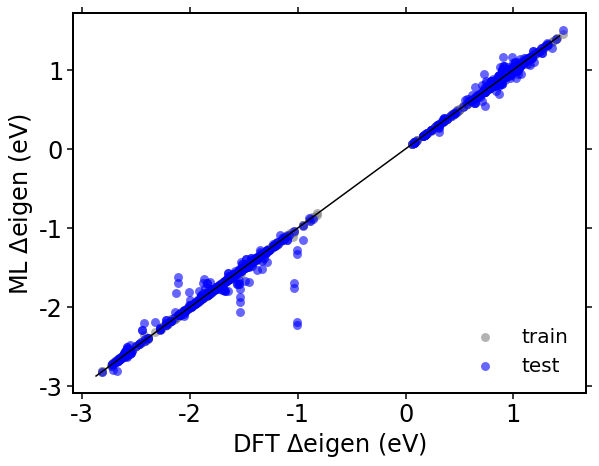

(8448, 16)
(8448,)
random seed 79
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(6758,) (1690,)
0 RMSE 0.026360376506711646
0 MAE 0.011440962248267515
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(6758,) (1690,)
1 RMSE 0.024408035692023017
1 MAE 0.00483838027982825
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.01}
(6758,) (1690,)
2 RMSE 0.022013715116390387
2 MAE 0.0045153182369204025
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.1}
(6758,) (1690,)
3 RMSE 0.020697732572199326
3 MAE 0.004073389011112122
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-05, 'gamma': 1.0}
(6758,) (1690,)
4 RMSE 0.03251613097278267
4 MAE 0.005324236724368505
best parameters gamma: 0.1 alpha: 1e-06
('MAE TRAIN ERROR', 0.00059875064255674)
('MAE TEST ERROR', 0.004073389011112122)


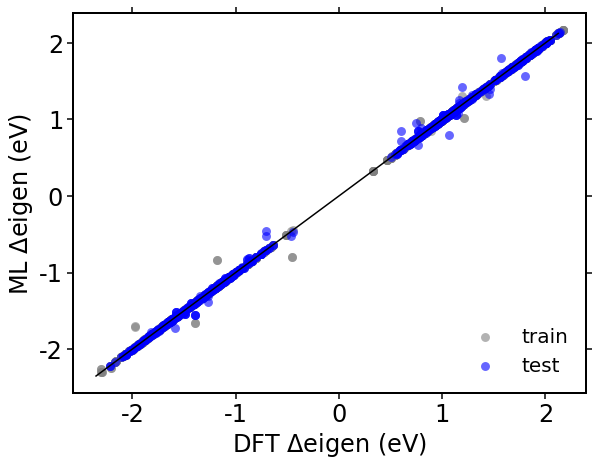

(7384, 16)
(7384,)
random seed 149
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(5907,) (1477,)
0 RMSE 0.04625949071469285
0 MAE 0.024009181279925764
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(5907,) (1477,)
1 RMSE 0.03705571123586059
1 MAE 0.01346078631505598
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.01}
(5907,) (1477,)
2 RMSE 0.03842062908085294
2 MAE 0.013999664791989224
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.0001, 'gamma': 0.1}
(5907,) (1477,)
3 RMSE 0.04952454487280822
3 MAE 0.025919051416637737
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.001, 'gamma': 1.0}
(5907,) (1477,)
4 RMSE 0.05758303811752594
4 MAE 0.02769854646354536
best parameters gamma: 0.001 alpha: 1e-07
('MAE TRAIN ERROR', 0.00356573949455238)
('MAE TEST ERROR', 0.01346078631505598)


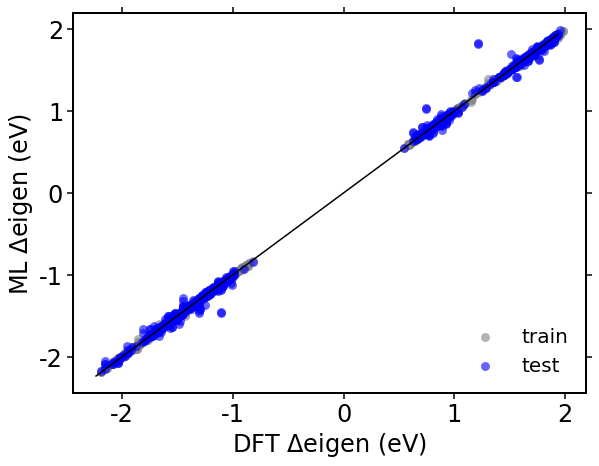

(6552, 16)
(6552,)
random seed 73
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(5241,) (1311,)
0 RMSE 0.02541798949784341
0 MAE 0.011085261077466034
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(5241,) (1311,)
1 RMSE 0.02033213815524844
1 MAE 0.005644921187285771
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.01}
(5241,) (1311,)
2 RMSE 0.022051227632593103
2 MAE 0.00602424260065431
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-05, 'gamma': 0.1}
(5241,) (1311,)
3 RMSE 0.025784548188970767
3 MAE 0.006673381224672019
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.0001, 'gamma': 1.0}
(5241,) (1311,)
4 RMSE 0.02767007882181101
4 MAE 0.007519303612887415
best parameters gamma: 0.001 alpha: 1e-07
('MAE TRAIN ERROR', 0.002317266067465023)
('MAE TEST ERROR', 0.005644921187285771)


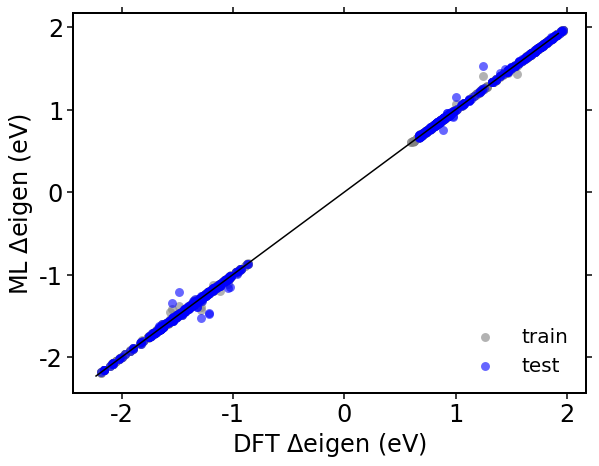

(11008, 16)
(11008,)
random seed 287
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(8806,) (2202,)
0 RMSE 0.026377995609183358
0 MAE 0.010848654614705308
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(8806,) (2202,)
1 RMSE 0.018790092483416197
1 MAE 0.004037859505547845
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.01}
(8806,) (2202,)
2 RMSE 0.01875268180832861
2 MAE 0.002790467754733428
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.1}
(8806,) (2202,)
3 RMSE 0.02163562467521191
3 MAE 0.002923193444986829
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 1.0}
(8806,) (2202,)
4 RMSE 0.02122134580464337
4 MAE 0.002726991071783966
best parameters gamma: 1.0 alpha: 1e-07
('MAE TRAIN ERROR', 1.4593265515534367e-06)
('MAE TEST ERROR', 0.002726991071783966)


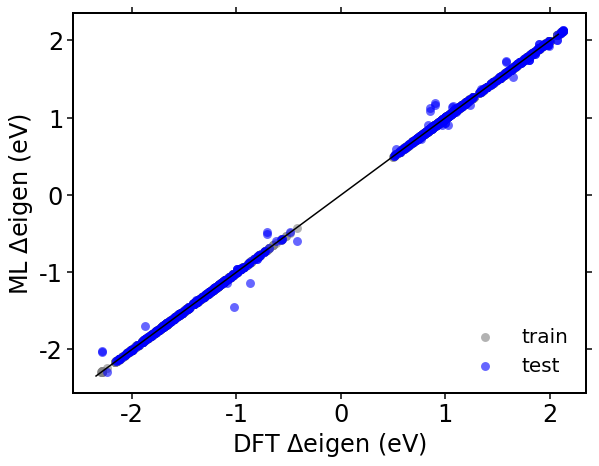

(8448, 16)
(8448,)
random seed 570
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(6758,) (1690,)
0 RMSE 0.04230631076431892
0 MAE 0.015511105752896314
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(6758,) (1690,)
1 RMSE 0.03762162609424812
1 MAE 0.007148431623431601
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.01}
(6758,) (1690,)
2 RMSE 0.03889676633269807
2 MAE 0.006461976383668747
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.1}
(6758,) (1690,)
3 RMSE 0.04223156181505181
3 MAE 0.005943426118481495
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 1.0}
(6758,) (1690,)
4 RMSE 0.04162767595956913
4 MAE 0.005849427121388516
best parameters gamma: 1.0 alpha: 1e-07
('MAE TRAIN ERROR', 0.00040492023451297986)
('MAE TEST ERROR', 0.005849427121388516)


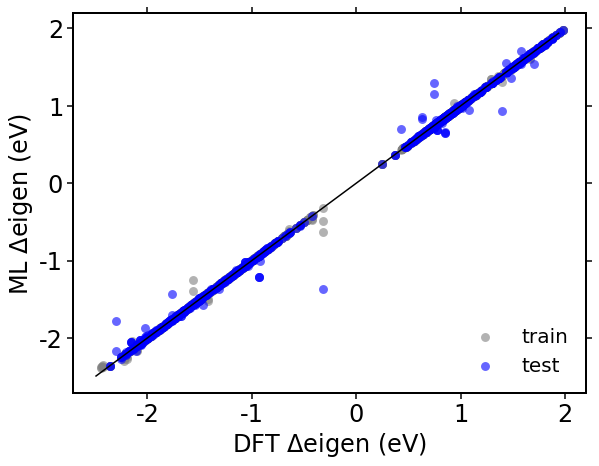

(7384, 16)
(7384,)
random seed 79
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(5907,) (1477,)
0 RMSE 0.04722555216104767
0 MAE 0.024845315970009427
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(5907,) (1477,)
1 RMSE 0.03557799949698351
1 MAE 0.014144390278546281
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.01}
(5907,) (1477,)
2 RMSE 0.03784426197566288
2 MAE 0.01373690009982475
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-05, 'gamma': 0.1}
(5907,) (1477,)
3 RMSE 0.04846711495408361
3 MAE 0.020730005884059616
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.001, 'gamma': 1.0}
(5907,) (1477,)
4 RMSE 0.06164820613227637
4 MAE 0.028349546839715998
best parameters gamma: 0.01 alpha: 1e-07
('MAE TRAIN ERROR', 0.0004974639613323064)
('MAE TEST ERROR', 0.01373690009982475)


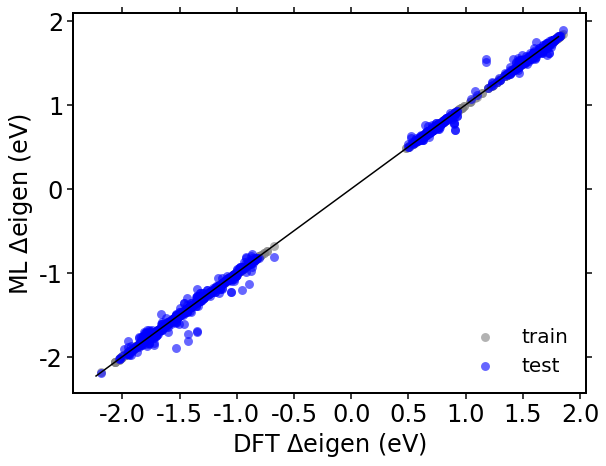

(6552, 16)
(6552,)
random seed 149
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(5241,) (1311,)
0 RMSE 0.03341823587989906
0 MAE 0.011449804656527724
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(5241,) (1311,)
1 RMSE 0.028767785199858894
1 MAE 0.006543156553786173
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.01}
(5241,) (1311,)
2 RMSE 0.031124796759698523
2 MAE 0.006342802280458662
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-05, 'gamma': 0.1}
(5241,) (1311,)
3 RMSE 0.034955438982773084
3 MAE 0.009004822665674428
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.0001, 'gamma': 1.0}
(5241,) (1311,)
4 RMSE 0.04189949064886507
4 MAE 0.012254063497254592
best parameters gamma: 0.01 alpha: 1e-07
('MAE TRAIN ERROR', 0.0006396728117458241)
('MAE TEST ERROR', 0.006342802280458662)


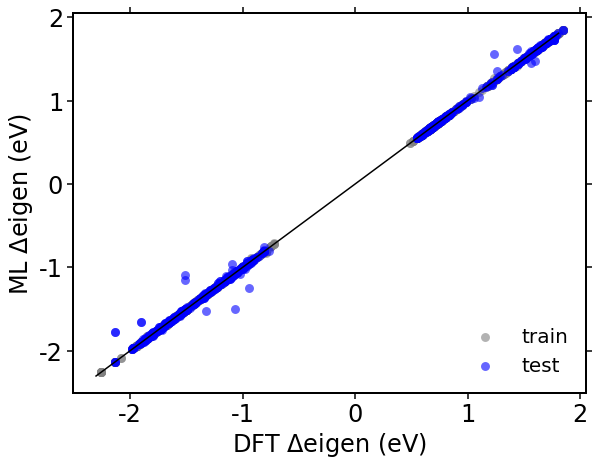

(11008, 16)
(11008,)
random seed 73
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(8806,) (2202,)
0 RMSE 0.03256830847958974
0 MAE 0.013971823647735356
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(8806,) (2202,)
1 RMSE 0.02312718212894032
1 MAE 0.005652922334752313
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.01}
(8806,) (2202,)
2 RMSE 0.02105770167532854
2 MAE 0.004534041798707172
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-05, 'gamma': 0.1}
(8806,) (2202,)
3 RMSE 0.02294946123165054
3 MAE 0.004010358157453542
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.001, 'gamma': 1.0}
(8806,) (2202,)
4 RMSE 0.027849061141097236
4 MAE 0.004829415940343403
best parameters gamma: 0.1 alpha: 1e-05
('MAE TRAIN ERROR', 0.0006474012708045243)
('MAE TEST ERROR', 0.004010358157453542)


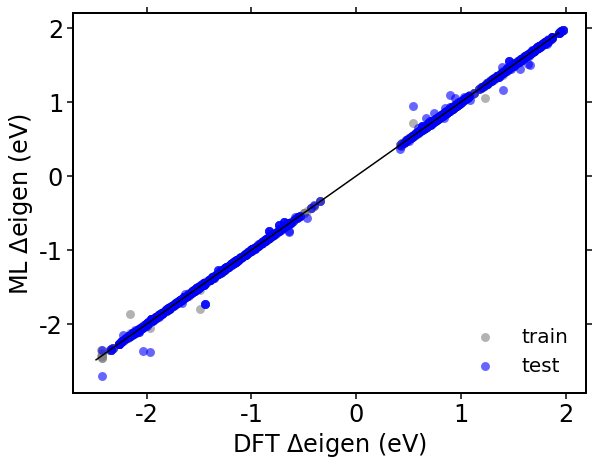

(7488, 16)
(7488,)
random seed 287
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(5990,) (1498,)
0 RMSE 0.0035405949512300177
0 MAE 0.001497260928842025
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(5990,) (1498,)
1 RMSE 0.0029810176608101443
1 MAE 0.000591747405865787
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.01}
(5990,) (1498,)
2 RMSE 0.0027018643473743463
2 MAE 0.0003713954293289415
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.1}
(5990,) (1498,)
3 RMSE 0.0023727978495402826
3 MAE 0.0003194776314347427
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 1.0}
(5990,) (1498,)
4 RMSE 0.002145657127574268
4 MAE 0.0002501475045128215
best parameters gamma: 1.0 alpha: 1e-07
('MAE TRAIN ERROR', 6.919945730366455e-08)
('MAE TEST ERROR', 0.0002501475045128215)


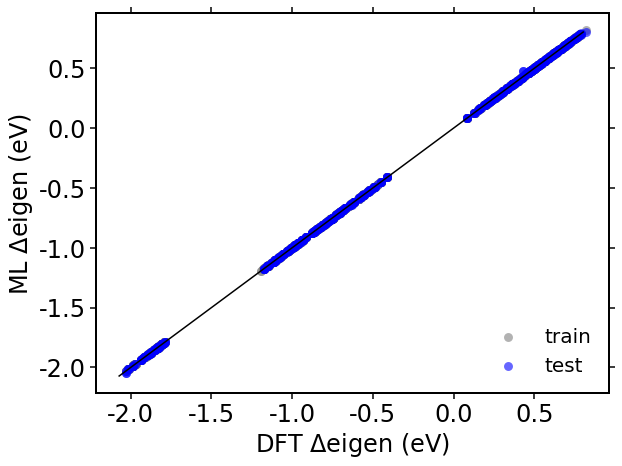

(6656, 16)
(6656,)
random seed 570
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(5324,) (1332,)
0 RMSE 0.0062694659394877655
0 MAE 0.002159665720964064
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(5324,) (1332,)
1 RMSE 0.005759390394050644
1 MAE 0.0008599048581961458
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.01}
(5324,) (1332,)
2 RMSE 0.005730513601511443
2 MAE 0.0005437249252565578
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.1}
(5324,) (1332,)
3 RMSE 0.005434125269430767
3 MAE 0.0004796923549074942
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 1.0}
(5324,) (1332,)
4 RMSE 0.005490196271350903
4 MAE 0.00046242288564117296
best parameters gamma: 1.0 alpha: 1e-06
('MAE TRAIN ERROR', 2.362808485278833e-05)
('MAE TEST ERROR', 0.00046242288564117296)


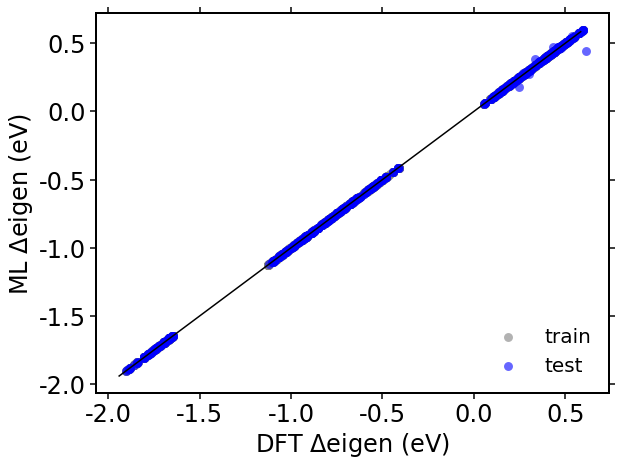

(4680, 16)
(4680,)
random seed 79
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(3744,) (936,)
0 RMSE 0.0012203286292974892
0 MAE 0.0004223270864830749
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(3744,) (936,)
1 RMSE 0.0005683308942262246
1 MAE 9.871481806566855e-05
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.01}
(3744,) (936,)
2 RMSE 0.0006310303478302019
2 MAE 7.26819605649165e-05
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.1}
(3744,) (936,)
3 RMSE 0.000643273626299181
3 MAE 7.031544214158615e-05
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 1.0}
(3744,) (936,)
4 RMSE 0.003330634209232828
4 MAE 0.00014114680616849205
best parameters gamma: 0.1 alpha: 1e-06
('MAE TRAIN ERROR', 2.1879672747156748e-05)
('MAE TEST ERROR', 7.031544214158615e-05)


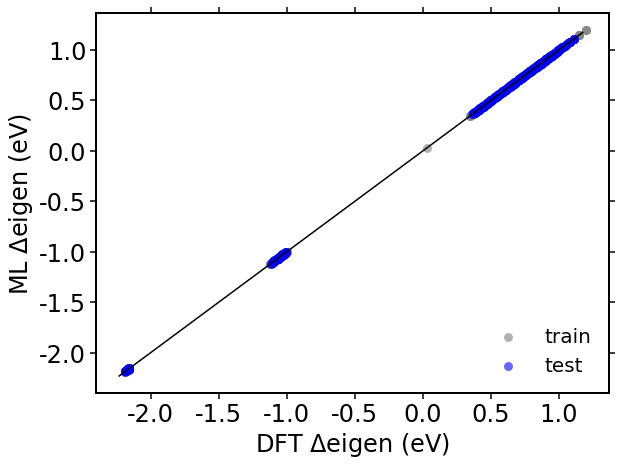

(4128, 16)
(4128,)
random seed 149
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(3302,) (826,)
0 RMSE 0.01865824947817004
0 MAE 0.0028861912330896827
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(3302,) (826,)
1 RMSE 0.017500713831978515
1 MAE 0.001956677238643477
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.01}
(3302,) (826,)
2 RMSE 0.016508869732449315
2 MAE 0.0018675747513614822
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.1}
(3302,) (826,)
3 RMSE 0.015334196202041695
3 MAE 0.0015732456521203551
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 1.0}
(3302,) (826,)
4 RMSE 0.023817348176235417
4 MAE 0.0017634715235678008
best parameters gamma: 0.1 alpha: 1e-07
('MAE TRAIN ERROR', 8.811438743194758e-05)
('MAE TEST ERROR', 0.0015732456521203551)


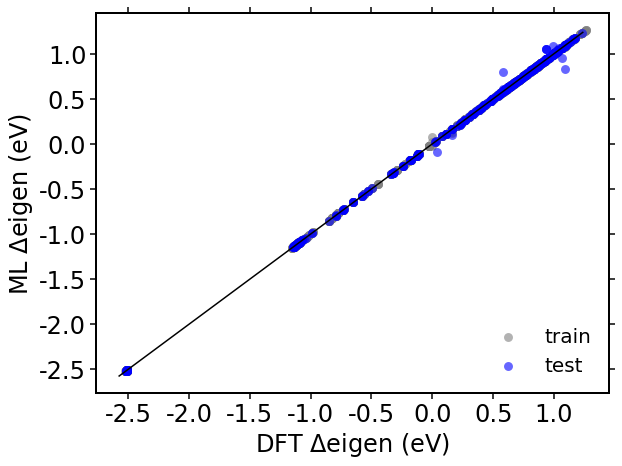

(12384, 16)
(12384,)
random seed 73
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(9907,) (2477,)
0 RMSE 0.024776492856817083
0 MAE 0.01118752642739176
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(9907,) (2477,)
1 RMSE 0.019525098605658164
1 MAE 0.00538272572762301
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.01}
(9907,) (2477,)
2 RMSE 0.018147941779589456
2 MAE 0.0031746282510266154
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.1}
(9907,) (2477,)
3 RMSE 0.022879094086927603
3 MAE 0.0028917610787827825
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 1.0}
(9907,) (2477,)
4 RMSE 0.03350742425828169
4 MAE 0.003194027136134435
best parameters gamma: 0.1 alpha: 1e-07
('MAE TRAIN ERROR', 7.22680759740893e-06)
('MAE TEST ERROR', 0.0028917610787827825)


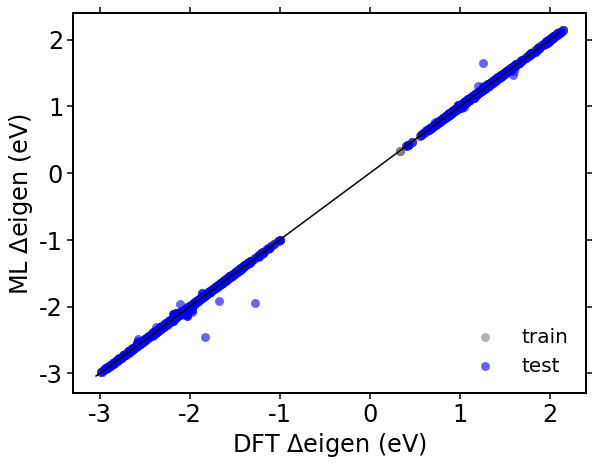

(5200, 16)
(5200,)
random seed 287
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(4160,) (1040,)
0 RMSE 0.012273177403018658
0 MAE 0.0009300135795772321
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(4160,) (1040,)
1 RMSE 0.01206979972196769
1 MAE 0.0007210300893944466
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.01}
(4160,) (1040,)
2 RMSE 0.009492073303947624
2 MAE 0.0005565994359483585
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-05, 'gamma': 0.1}
(4160,) (1040,)
3 RMSE 0.006365898223080096
3 MAE 0.0003465483961314031
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.001, 'gamma': 1.0}
(4160,) (1040,)
4 RMSE 0.01029820064180921
4 MAE 0.0006644614876745409
best parameters gamma: 0.1 alpha: 1e-05
('MAE TRAIN ERROR', 1.9370918908948278e-05)
('MAE TEST ERROR', 0.0003465483961314031)


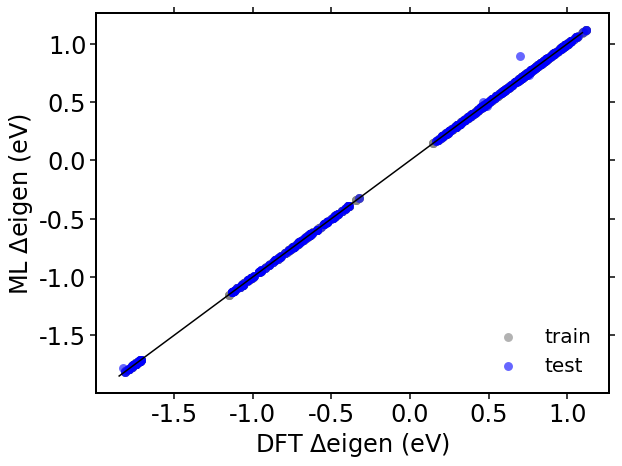

(5200, 16)
(5200,)
random seed 570
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(4160,) (1040,)
0 RMSE 0.0004932436986298433
0 MAE 0.00020369785521374598
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.001}
(4160,) (1040,)
1 RMSE 0.00047606525155638457
1 MAE 0.00019209184820924227
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-05, 'gamma': 0.01}
(4160,) (1040,)
2 RMSE 0.00040497645650441015
2 MAE 0.0001514070768059081
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.1}
(4160,) (1040,)
3 RMSE 0.00027013337015397923
3 MAE 1.7927285945337995e-05
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 1.0}
(4160,) (1040,)
4 RMSE 0.0002887480208178713
4 MAE 1.5756821254904955e-05
best parameters gamma: 1.0 alpha: 1e-07
('MAE TRAIN ERROR', 2.269528712159519e-05)
('MAE TEST ERROR', 1.5756821254904955e-05)


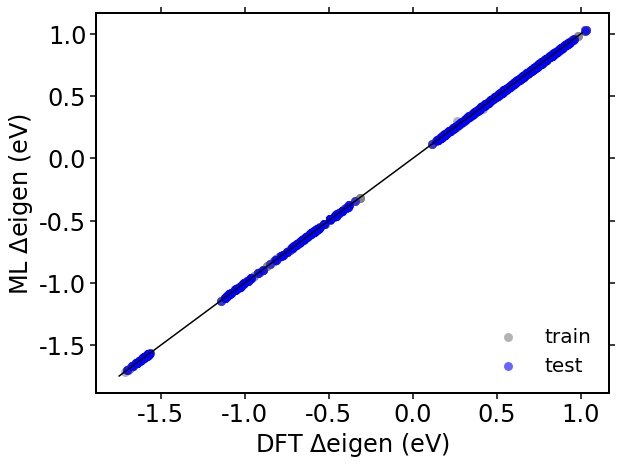

(7280, 16)
(7280,)
random seed 79
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(5824,) (1456,)
0 RMSE 0.0027619434175603203
0 MAE 0.0006414745734239348
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(5824,) (1456,)
1 RMSE 0.002588962591482079
1 MAE 0.0002767788820579502
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.01}
(5824,) (1456,)
2 RMSE 0.0025216086492947454
2 MAE 0.0002143625214276679
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.1}
(5824,) (1456,)
3 RMSE 0.00216870255451552
3 MAE 0.00018820211029330641
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 1.0}
(5824,) (1456,)
4 RMSE 0.0012610177632322447
4 MAE 0.00011225971264810898
best parameters gamma: 1.0 alpha: 1e-07
('MAE TRAIN ERROR', 2.1579192919732775e-05)
('MAE TEST ERROR', 0.00011225971264810898)


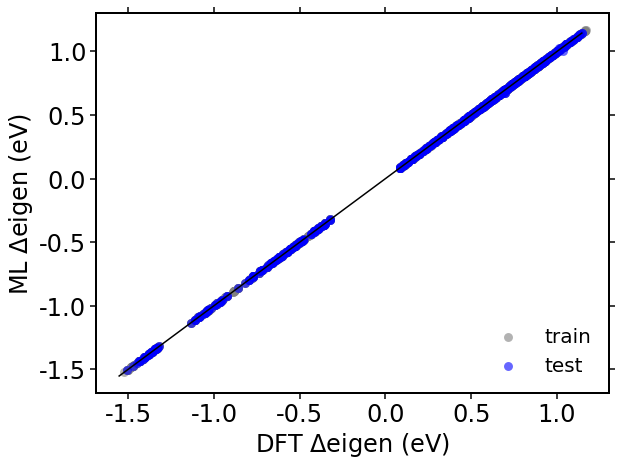

(4160, 16)
(4160,)
random seed 149
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(3328,) (832,)
0 RMSE 0.004244930988433911
0 MAE 0.0011333697772974135
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.001}
(3328,) (832,)
1 RMSE 0.004271260442641691
1 MAE 0.001076886103958391
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.01}
(3328,) (832,)
2 RMSE 0.004825291598227869
2 MAE 0.0004526555683411882
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.0001, 'gamma': 0.1}
(3328,) (832,)
3 RMSE 0.01098439569724113
3 MAE 0.0007725599647782892
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-05, 'gamma': 1.0}
(3328,) (832,)
4 RMSE 0.03923210816183161
4 MAE 0.001515736000559756
best parameters gamma: 0.01 alpha: 1e-06
('MAE TRAIN ERROR', 6.490611984941635e-05)
('MAE TEST ERROR', 0.0004526555683411882)


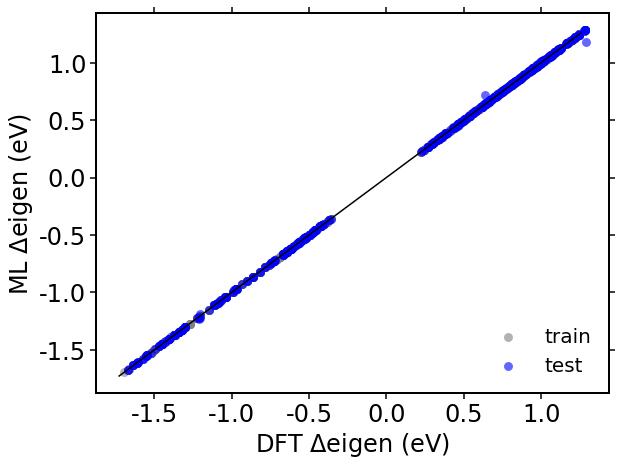

(7280, 16)
(7280,)
random seed 73
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(5824,) (1456,)
0 RMSE 0.003222380074867413
0 MAE 0.000833891940822726
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(5824,) (1456,)
1 RMSE 0.003108130693364715
1 MAE 0.0003382649395024342
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.01}
(5824,) (1456,)
2 RMSE 0.003306891664226215
2 MAE 0.0002829412954938665
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.1}
(5824,) (1456,)
3 RMSE 0.0017277923621705923
3 MAE 0.00016514844970219776
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-05, 'gamma': 1.0}
(5824,) (1456,)
4 RMSE 0.005487446158611528
4 MAE 0.0003815252204130966
best parameters gamma: 0.1 alpha: 1e-06
('MAE TRAIN ERROR', 4.275045864355045e-05)
('MAE TEST ERROR', 0.00016514844970219776)


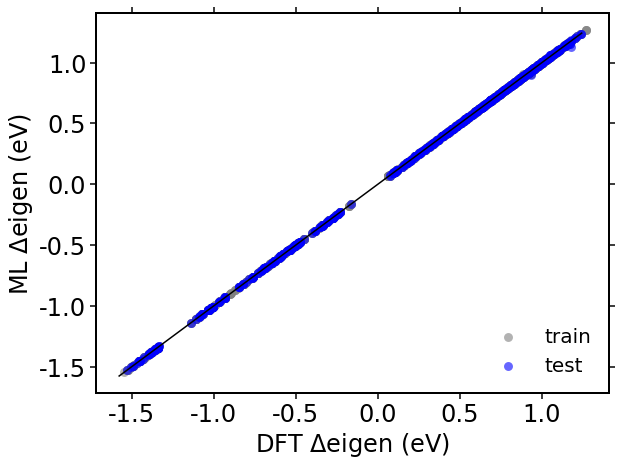

(6720, 16)
(6720,)
random seed 287
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(5376,) (1344,)
0 RMSE 0.005208513787873827
0 MAE 0.0007993086069323392
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(5376,) (1344,)
1 RMSE 0.005687605009735161
1 MAE 0.0005665471791172638
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.01}
(5376,) (1344,)
2 RMSE 0.006309160241015981
2 MAE 0.0005052406337653308
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-05, 'gamma': 0.1}
(5376,) (1344,)
3 RMSE 0.004571160210734795
3 MAE 0.00038130723872177157
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.0001, 'gamma': 1.0}
(5376,) (1344,)
4 RMSE 0.007693682332468886
4 MAE 0.0006661054435089453
best parameters gamma: 0.1 alpha: 1e-05
('MAE TRAIN ERROR', 0.0001114487857926696)
('MAE TEST ERROR', 0.00038130723872177157)


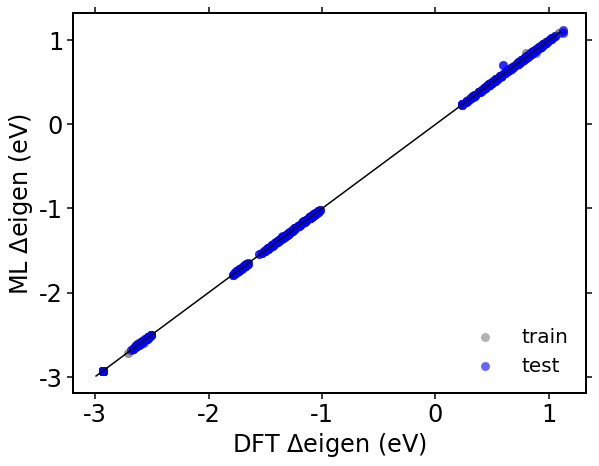

(9472, 16)
(9472,)
random seed 570
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(7577,) (1895,)
0 RMSE 0.004867267568899182
0 MAE 0.001429734213341038
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(7577,) (1895,)
1 RMSE 0.004261489697553777
1 MAE 0.0005074968823988807
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.01}
(7577,) (1895,)
2 RMSE 0.0038104638465161177
2 MAE 0.0004356309040119355
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-05, 'gamma': 0.1}
(7577,) (1895,)
3 RMSE 0.002919736986225312
3 MAE 0.0003397442825710672
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 1.0}
(7577,) (1895,)
4 RMSE 0.002905905023109502
4 MAE 0.00030992983025906475
best parameters gamma: 1.0 alpha: 1e-07
('MAE TRAIN ERROR', 1.8613178956687654e-06)
('MAE TEST ERROR', 0.00030992983025906475)


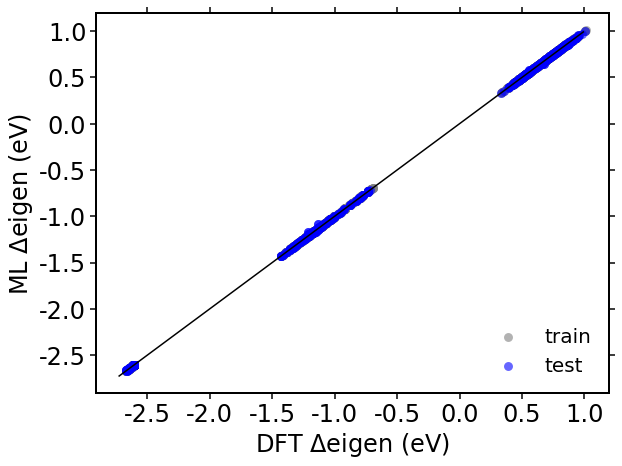

(8512, 16)
(8512,)
random seed 79
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(6809,) (1703,)
0 RMSE 0.013548346842616363
0 MAE 0.0027966907174445496
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.001}
(6809,) (1703,)
1 RMSE 0.012776246815602238
1 MAE 0.002495921684749928
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-05, 'gamma': 0.01}
(6809,) (1703,)
2 RMSE 0.01179452715464589
2 MAE 0.0020958969558922376
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.0001, 'gamma': 0.1}
(6809,) (1703,)
3 RMSE 0.011762756946779739
3 MAE 0.0016822111250770998
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 1.0}
(6809,) (1703,)
4 RMSE 0.01356452646899451
4 MAE 0.0010818051237739099
best parameters gamma: 1.0 alpha: 1e-07
('MAE TRAIN ERROR', 1.306673403843307e-05)
('MAE TEST ERROR', 0.0010818051237739099)


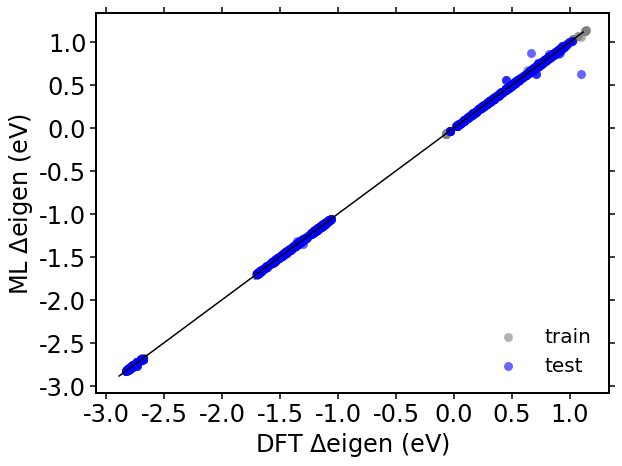

(10320, 16)
(10320,)
random seed 149
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(8256,) (2064,)
0 RMSE 0.004909651633521565
0 MAE 0.0020587140330574623
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.001}
(8256,) (2064,)
1 RMSE 0.0032827980254992186
1 MAE 0.0005904366332883558
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.01}
(8256,) (2064,)
2 RMSE 0.0033424434561386686
2 MAE 0.0002768171676270485
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.1}
(8256,) (2064,)
3 RMSE 0.002368055337302003
3 MAE 0.00020729502300056705
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 1.0}
(8256,) (2064,)
4 RMSE 0.0031717736069213887
4 MAE 0.00021019087277259193
best parameters gamma: 0.1 alpha: 1e-06
('MAE TRAIN ERROR', 6.834402326675825e-06)
('MAE TEST ERROR', 0.00020729502300056705)


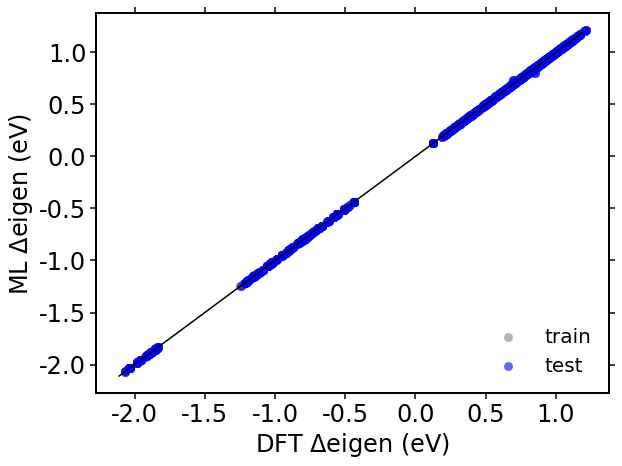

(12480, 16)
(12480,)
random seed 73
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.0001}
(9984,) (2496,)
0 RMSE 0.03614189167772066
0 MAE 0.002312332806934889
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-05, 'gamma': 0.001}
(9984,) (2496,)
1 RMSE 0.035307731081311196
1 MAE 0.0022119550642627586
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.0001, 'gamma': 0.01}
(9984,) (2496,)
2 RMSE 0.03272593519891964
2 MAE 0.0018987042112772212
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.1}
(9984,) (2496,)
3 RMSE 0.024958003774917685
3 MAE 0.0007950921552782915
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 1.0}
(9984,) (2496,)
4 RMSE 0.015485113154140435
4 MAE 0.0005282559945302942
best parameters gamma: 1.0 alpha: 1e-06
('MAE TRAIN ERROR', 0.00013593827207550343)
('MAE TEST ERROR', 0.0005282559945302942)


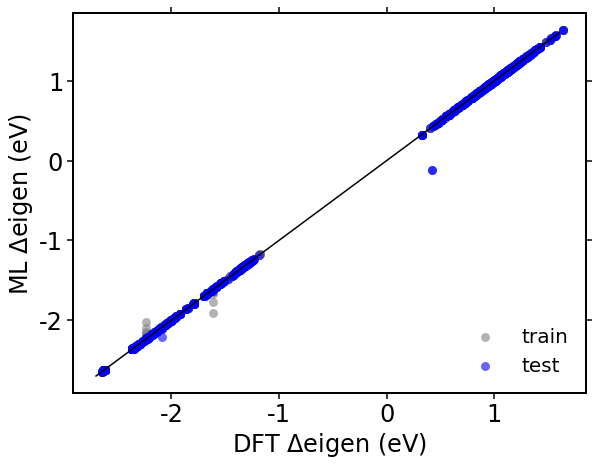

(9504, 16)
(9504,)
random seed 287
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 0.0001}
(7603,) (1901,)
0 RMSE 0.013527612698741573
0 MAE 0.0037670462617579305
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-06, 'gamma': 0.001}
(7603,) (1901,)
1 RMSE 0.012665051902477166
1 MAE 0.003149509612567387
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-05, 'gamma': 0.01}
(7603,) (1901,)
2 RMSE 0.011790753560111032
2 MAE 0.002283616149395078
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.0001, 'gamma': 0.1}
(7603,) (1901,)
3 RMSE 0.011311959162621654
3 MAE 0.001498360559058104
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1e-07, 'gamma': 1.0}
(7603,) (1901,)
4 RMSE 0.00737720767348818
4 MAE 0.00046259911636355395
best parameters gamma: 1.0 alpha: 1e-07
('MAE TRAIN ERROR', 3.4936673313584695e-05)
('MAE TEST ERROR', 0.00046259911636355395)


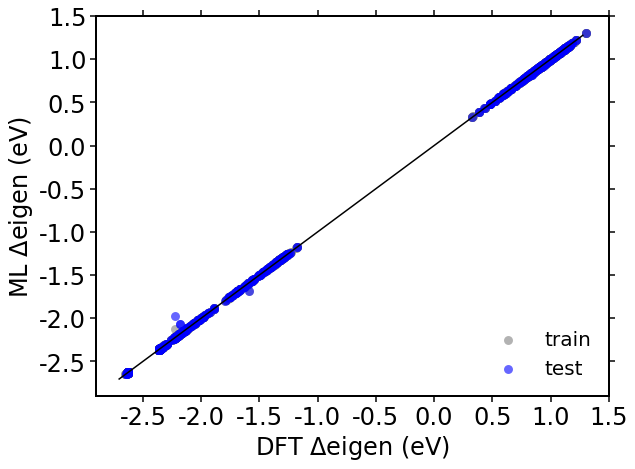

In [4]:
cwd=os.getcwd()
atom_path=os.path.join(cwd,'atom_sum_compound_csv_files/')
concat_path=os.path.join(cwd,'special_concatenations_compounds_atom_sum/')
listdir_cwd=os.listdir(cwd)
#print(listdir)
check=['atom_sum_compound_csv_files','special_concatenations_compounds_atom_sum']
for entries in check:
    if entries not in listdir_cwd:
        file=tarfile.open(str(entries)+'.tar.gz')
        file.extractall()
        file.close
    else:
        print ('%s %s'%(entries,'exists'))

list_atom_files=os.listdir(atom_path)
#print(list_atom_files)
final_list=[]
for name in list_atom_files:
    train_err,test_err,gamma,alpha=best_fit(atom_path+str(name))
    list1=[str(name),train_err,test_err,gamma,alpha]
    final_list.append(list1)
#print(cwd)
#print(atom_path)
#path=cwd+'/Ag2O1.csv'
#train_err,test_err,gamma,alpha=best_fit(path)
#print('At last')
#print(train_err,test_err,gamma,alpha)


In [5]:
heading=['compound','train_err','test_err','gamma','alpha']
dataframe=pd.DataFrame(final_list,columns=heading)
dataframe.to_csv('alpha_gamma.csv')